In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1944281, 828)
(1944281, 8)
validation
(230665, 828)
(230665, 8)
test
(282706, 828)
(282706, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/195 [..............................] - ETA: 5:14 - loss: 2.1688 - STD: 0.0608 - MAE: 0.2169

  4/195 [..............................] - ETA: 4s - loss: 2.0933 - STD: 0.0490 - MAE: 0.2163  

  7/195 [>.............................] - ETA: 4s - loss: 2.0847 - STD: 0.0408 - MAE: 0.2168

 10/195 [>.............................] - ETA: 4s - loss: 2.0735 - STD: 0.0399 - MAE: 0.2166

 13/195 [=>............................] - ETA: 4s - loss: 2.0676 - STD: 0.0404 - MAE: 0.2164

 16/195 [=>............................] - ETA: 4s - loss: 2.0633 - STD: 0.0396 - MAE: 0.2164

 19/195 [=>............................] - ETA: 4s - loss: 2.0575 - STD: 0.0389 - MAE: 0.2162

 21/195 [==>...........................] - ETA: 11s - loss: 2.0546 - STD: 0.0388 - MAE: 0.2161

 24/195 [==>...........................] - ETA: 10s - loss: 2.0474 - STD: 0.0385 - MAE: 0.2159

 27/195 [===>..........................] - ETA: 9s - loss: 2.0383 - STD: 0.0393 - MAE: 0.2155 

 30/195 [===>..........................] - ETA: 8s - loss: 2.0283 - STD: 0.0412 - MAE: 0.2150

 33/195 [====>.........................] - ETA: 7s - loss: 2.0175 - STD: 0.0437 - MAE: 0.2143

 36/195 [====>.........................] - ETA: 7s - loss: 2.0055 - STD: 0.0457 - MAE: 0.2137

 39/195 [=====>........................] - ETA: 7s - loss: 1.9927 - STD: 0.0476 - MAE: 0.2131

 42/195 [=====>........................] - ETA: 6s - loss: 1.9783 - STD: 0.0497 - MAE: 0.2124

 45/195 [=====>........................] - ETA: 6s - loss: 1.9626 - STD: 0.0521 - MAE: 0.2116

 48/195 [======>.......................] - ETA: 6s - loss: 1.9459 - STD: 0.0546 - MAE: 0.2107

 51/195 [======>.......................] - ETA: 5s - loss: 1.9284 - STD: 0.0572 - MAE: 0.2098

 54/195 [=======>......................] - ETA: 5s - loss: 1.9100 - STD: 0.0599 - MAE: 0.2087

 57/195 [=======>......................] - ETA: 5s - loss: 1.8920 - STD: 0.0627 - MAE: 0.2077

 60/195 [========>.....................] - ETA: 5s - loss: 1.8739 - STD: 0.0654 - MAE: 0.2067

 63/195 [========>.....................] - ETA: 4s - loss: 1.8567 - STD: 0.0682 - MAE: 0.2056

 66/195 [=========>....................] - ETA: 4s - loss: 1.8400 - STD: 0.0708 - MAE: 0.2046

 69/195 [=========>....................] - ETA: 4s - loss: 1.8238 - STD: 0.0734 - MAE: 0.2035

 72/195 [==========>...................] - ETA: 4s - loss: 1.8083 - STD: 0.0759 - MAE: 0.2025

 75/195 [==========>...................] - ETA: 4s - loss: 1.7935 - STD: 0.0782 - MAE: 0.2016

 78/195 [===========>..................] - ETA: 3s - loss: 1.7789 - STD: 0.0805 - MAE: 0.2006

 81/195 [===========>..................] - ETA: 3s - loss: 1.7651 - STD: 0.0827 - MAE: 0.1997

 84/195 [===========>..................] - ETA: 3s - loss: 1.7518 - STD: 0.0848 - MAE: 0.1988

 87/195 [============>.................] - ETA: 3s - loss: 1.7391 - STD: 0.0869 - MAE: 0.1979

 90/195 [============>.................] - ETA: 3s - loss: 1.7270 - STD: 0.0889 - MAE: 0.1971

 93/195 [=============>................] - ETA: 3s - loss: 1.7154 - STD: 0.0908 - MAE: 0.1963

 96/195 [=============>................] - ETA: 3s - loss: 1.7044 - STD: 0.0926 - MAE: 0.1955

 99/195 [==============>...............] - ETA: 3s - loss: 1.6938 - STD: 0.0944 - MAE: 0.1947

102/195 [==============>...............] - ETA: 2s - loss: 1.6839 - STD: 0.0961 - MAE: 0.1940

105/195 [===============>..............] - ETA: 2s - loss: 1.6742 - STD: 0.0978 - MAE: 0.1932

108/195 [===============>..............] - ETA: 2s - loss: 1.6649 - STD: 0.0994 - MAE: 0.1925

111/195 [================>.............] - ETA: 2s - loss: 1.6560 - STD: 0.1009 - MAE: 0.1919

114/195 [================>.............] - ETA: 2s - loss: 1.6473 - STD: 0.1023 - MAE: 0.1912

117/195 [=================>............] - ETA: 2s - loss: 1.6387 - STD: 0.1038 - MAE: 0.1906

120/195 [=================>............] - ETA: 2s - loss: 1.6305 - STD: 0.1051 - MAE: 0.1899

123/195 [=================>............] - ETA: 2s - loss: 1.6227 - STD: 0.1064 - MAE: 0.1893

126/195 [==================>...........] - ETA: 2s - loss: 1.6151 - STD: 0.1077 - MAE: 0.1888

129/195 [==================>...........] - ETA: 1s - loss: 1.6078 - STD: 0.1089 - MAE: 0.1882

132/195 [===================>..........] - ETA: 1s - loss: 1.6009 - STD: 0.1101 - MAE: 0.1877

135/195 [===================>..........] - ETA: 1s - loss: 1.5941 - STD: 0.1113 - MAE: 0.1871

138/195 [====================>.........] - ETA: 1s - loss: 1.5876 - STD: 0.1124 - MAE: 0.1866

141/195 [====================>.........] - ETA: 1s - loss: 1.5812 - STD: 0.1135 - MAE: 0.1861

144/195 [=====================>........] - ETA: 1s - loss: 1.5749 - STD: 0.1145 - MAE: 0.1856

147/195 [=====================>........] - ETA: 1s - loss: 1.5689 - STD: 0.1156 - MAE: 0.1851

150/195 [======================>.......] - ETA: 1s - loss: 1.5631 - STD: 0.1166 - MAE: 0.1847

153/195 [======================>.......] - ETA: 1s - loss: 1.5574 - STD: 0.1175 - MAE: 0.1842

156/195 [=======================>......] - ETA: 1s - loss: 1.5518 - STD: 0.1185 - MAE: 0.1838

159/195 [=======================>......] - ETA: 1s - loss: 1.5464 - STD: 0.1194 - MAE: 0.1833

162/195 [=======================>......] - ETA: 0s - loss: 1.5411 - STD: 0.1203 - MAE: 0.1829

165/195 [========================>.....] - ETA: 0s - loss: 1.5360 - STD: 0.1212 - MAE: 0.1825

168/195 [========================>.....] - ETA: 0s - loss: 1.5308 - STD: 0.1220 - MAE: 0.1820

171/195 [=========================>....] - ETA: 0s - loss: 1.5258 - STD: 0.1229 - MAE: 0.1816

174/195 [=========================>....] - ETA: 0s - loss: 1.5211 - STD: 0.1237 - MAE: 0.1812

177/195 [==========================>...] - ETA: 0s - loss: 1.5164 - STD: 0.1245 - MAE: 0.1808

180/195 [==========================>...] - ETA: 0s - loss: 1.5117 - STD: 0.1253 - MAE: 0.1804

183/195 [===========================>..] - ETA: 0s - loss: 1.5072 - STD: 0.1261 - MAE: 0.1801

186/195 [===========================>..] - ETA: 0s - loss: 1.5030 - STD: 0.1269 - MAE: 0.1797

189/195 [============================>.] - ETA: 0s - loss: 1.4988 - STD: 0.1276 - MAE: 0.1793

192/195 [============================>.] - ETA: 0s - loss: 1.4946 - STD: 0.1283 - MAE: 0.1790

195/195 [==============================] - ETA: 0s - loss: 1.4905 - STD: 0.1290 - MAE: 0.1786

195/195 [==============================] - 8s 32ms/step - loss: 1.4905 - STD: 0.1290 - MAE: 0.1786 - val_loss: 1.3046 - val_STD: 0.1741 - val_MAE: 0.1575


Epoch 2/10000


  1/195 [..............................] - ETA: 11s - loss: 1.2230 - STD: 0.1753 - MAE: 0.1560

  4/195 [..............................] - ETA: 4s - loss: 1.2286 - STD: 0.1748 - MAE: 0.1561 

  7/195 [>.............................] - ETA: 4s - loss: 1.2274 - STD: 0.1745 - MAE: 0.1562

 10/195 [>.............................] - ETA: 4s - loss: 1.2256 - STD: 0.1746 - MAE: 0.1560

 13/195 [=>............................] - ETA: 4s - loss: 1.2232 - STD: 0.1750 - MAE: 0.1557

 16/195 [=>............................] - ETA: 4s - loss: 1.2215 - STD: 0.1753 - MAE: 0.1555

 19/195 [=>............................] - ETA: 4s - loss: 1.2204 - STD: 0.1755 - MAE: 0.1554

 22/195 [==>...........................] - ETA: 3s - loss: 1.2190 - STD: 0.1756 - MAE: 0.1553

 25/195 [==>...........................] - ETA: 3s - loss: 1.2174 - STD: 0.1757 - MAE: 0.1553

 28/195 [===>..........................] - ETA: 3s - loss: 1.2156 - STD: 0.1759 - MAE: 0.1551

 31/195 [===>..........................] - ETA: 3s - loss: 1.2141 - STD: 0.1762 - MAE: 0.1549

 34/195 [====>.........................] - ETA: 3s - loss: 1.2127 - STD: 0.1764 - MAE: 0.1548

 37/195 [====>.........................] - ETA: 3s - loss: 1.2119 - STD: 0.1765 - MAE: 0.1547

 40/195 [=====>........................] - ETA: 3s - loss: 1.2113 - STD: 0.1768 - MAE: 0.1546

 43/195 [=====>........................] - ETA: 3s - loss: 1.2105 - STD: 0.1770 - MAE: 0.1545

 46/195 [======>.......................] - ETA: 3s - loss: 1.2089 - STD: 0.1771 - MAE: 0.1544

 49/195 [======>.......................] - ETA: 3s - loss: 1.2075 - STD: 0.1772 - MAE: 0.1543

 52/195 [=======>......................] - ETA: 3s - loss: 1.2059 - STD: 0.1774 - MAE: 0.1541

 55/195 [=======>......................] - ETA: 3s - loss: 1.2049 - STD: 0.1776 - MAE: 0.1540

 58/195 [=======>......................] - ETA: 3s - loss: 1.2043 - STD: 0.1777 - MAE: 0.1539

 61/195 [========>.....................] - ETA: 3s - loss: 1.2044 - STD: 0.1779 - MAE: 0.1539

 64/195 [========>.....................] - ETA: 3s - loss: 1.2037 - STD: 0.1780 - MAE: 0.1538

 67/195 [=========>....................] - ETA: 2s - loss: 1.2026 - STD: 0.1782 - MAE: 0.1537

 70/195 [=========>....................] - ETA: 2s - loss: 1.2017 - STD: 0.1784 - MAE: 0.1536

 73/195 [==========>...................] - ETA: 2s - loss: 1.2005 - STD: 0.1785 - MAE: 0.1535

 76/195 [==========>...................] - ETA: 2s - loss: 1.1991 - STD: 0.1787 - MAE: 0.1533

 79/195 [===========>..................] - ETA: 2s - loss: 1.1980 - STD: 0.1789 - MAE: 0.1532

 82/195 [===========>..................] - ETA: 2s - loss: 1.1970 - STD: 0.1791 - MAE: 0.1531

 85/195 [============>.................] - ETA: 2s - loss: 1.1960 - STD: 0.1792 - MAE: 0.1530

 88/195 [============>.................] - ETA: 2s - loss: 1.1952 - STD: 0.1793 - MAE: 0.1529

 91/195 [=============>................] - ETA: 2s - loss: 1.1942 - STD: 0.1794 - MAE: 0.1528

 94/195 [=============>................] - ETA: 2s - loss: 1.1931 - STD: 0.1795 - MAE: 0.1527

 97/195 [=============>................] - ETA: 2s - loss: 1.1922 - STD: 0.1797 - MAE: 0.1526

100/195 [==============>...............] - ETA: 2s - loss: 1.1909 - STD: 0.1797 - MAE: 0.1525

103/195 [==============>...............] - ETA: 2s - loss: 1.1897 - STD: 0.1799 - MAE: 0.1524

106/195 [===============>..............] - ETA: 2s - loss: 1.1884 - STD: 0.1801 - MAE: 0.1523

109/195 [===============>..............] - ETA: 1s - loss: 1.1870 - STD: 0.1802 - MAE: 0.1521

112/195 [================>.............] - ETA: 1s - loss: 1.1866 - STD: 0.1804 - MAE: 0.1521

115/195 [================>.............] - ETA: 1s - loss: 1.1858 - STD: 0.1806 - MAE: 0.1520

118/195 [=================>............] - ETA: 1s - loss: 1.1853 - STD: 0.1807 - MAE: 0.1519

121/195 [=================>............] - ETA: 1s - loss: 1.1847 - STD: 0.1809 - MAE: 0.1518

124/195 [==================>...........] - ETA: 1s - loss: 1.1836 - STD: 0.1810 - MAE: 0.1517

127/195 [==================>...........] - ETA: 1s - loss: 1.1825 - STD: 0.1811 - MAE: 0.1516

130/195 [===================>..........] - ETA: 1s - loss: 1.1818 - STD: 0.1812 - MAE: 0.1515

133/195 [===================>..........] - ETA: 1s - loss: 1.1809 - STD: 0.1813 - MAE: 0.1514

136/195 [===================>..........] - ETA: 1s - loss: 1.1801 - STD: 0.1815 - MAE: 0.1514

139/195 [====================>.........] - ETA: 1s - loss: 1.1791 - STD: 0.1816 - MAE: 0.1512

142/195 [====================>.........] - ETA: 1s - loss: 1.1781 - STD: 0.1817 - MAE: 0.1512

145/195 [=====================>........] - ETA: 1s - loss: 1.1771 - STD: 0.1819 - MAE: 0.1511

148/195 [=====================>........] - ETA: 1s - loss: 1.1761 - STD: 0.1820 - MAE: 0.1510

151/195 [======================>.......] - ETA: 1s - loss: 1.1750 - STD: 0.1821 - MAE: 0.1509

154/195 [======================>.......] - ETA: 0s - loss: 1.1739 - STD: 0.1822 - MAE: 0.1507

157/195 [=======================>......] - ETA: 0s - loss: 1.1731 - STD: 0.1824 - MAE: 0.1507

160/195 [=======================>......] - ETA: 0s - loss: 1.1721 - STD: 0.1825 - MAE: 0.1506

163/195 [========================>.....] - ETA: 0s - loss: 1.1711 - STD: 0.1826 - MAE: 0.1505

166/195 [========================>.....] - ETA: 0s - loss: 1.1700 - STD: 0.1828 - MAE: 0.1504

169/195 [=========================>....] - ETA: 0s - loss: 1.1689 - STD: 0.1829 - MAE: 0.1502

172/195 [=========================>....] - ETA: 0s - loss: 1.1681 - STD: 0.1830 - MAE: 0.1502

175/195 [=========================>....] - ETA: 0s - loss: 1.1672 - STD: 0.1831 - MAE: 0.1501

178/195 [==========================>...] - ETA: 0s - loss: 1.1668 - STD: 0.1833 - MAE: 0.1500

181/195 [==========================>...] - ETA: 0s - loss: 1.1660 - STD: 0.1834 - MAE: 0.1499

184/195 [===========================>..] - ETA: 0s - loss: 1.1651 - STD: 0.1835 - MAE: 0.1498

187/195 [===========================>..] - ETA: 0s - loss: 1.1646 - STD: 0.1836 - MAE: 0.1497

190/195 [============================>.] - ETA: 0s - loss: 1.1637 - STD: 0.1837 - MAE: 0.1497

193/195 [============================>.] - ETA: 0s - loss: 1.1630 - STD: 0.1838 - MAE: 0.1496

195/195 [==============================] - 5s 25ms/step - loss: 1.1625 - STD: 0.1839 - MAE: 0.1495 - val_loss: 1.1840 - val_STD: 0.1918 - val_MAE: 0.1467


Epoch 3/10000


  1/195 [..............................] - ETA: 10s - loss: 1.1318 - STD: 0.1925 - MAE: 0.1450

  4/195 [..............................] - ETA: 4s - loss: 1.1284 - STD: 0.1914 - MAE: 0.1449 

  7/195 [>.............................] - ETA: 4s - loss: 1.1205 - STD: 0.1917 - MAE: 0.1444

 10/195 [>.............................] - ETA: 4s - loss: 1.1155 - STD: 0.1917 - MAE: 0.1442

 13/195 [=>............................] - ETA: 4s - loss: 1.1138 - STD: 0.1914 - MAE: 0.1442

 16/195 [=>............................] - ETA: 4s - loss: 1.1113 - STD: 0.1915 - MAE: 0.1440

 19/195 [=>............................] - ETA: 3s - loss: 1.1097 - STD: 0.1918 - MAE: 0.1438

 22/195 [==>...........................] - ETA: 3s - loss: 1.1085 - STD: 0.1918 - MAE: 0.1438

 25/195 [==>...........................] - ETA: 3s - loss: 1.1068 - STD: 0.1918 - MAE: 0.1437

 28/195 [===>..........................] - ETA: 3s - loss: 1.1056 - STD: 0.1920 - MAE: 0.1435

 31/195 [===>..........................] - ETA: 3s - loss: 1.1048 - STD: 0.1921 - MAE: 0.1435

 34/195 [====>.........................] - ETA: 3s - loss: 1.1039 - STD: 0.1921 - MAE: 0.1434

 37/195 [====>.........................] - ETA: 3s - loss: 1.1038 - STD: 0.1921 - MAE: 0.1434

 40/195 [=====>........................] - ETA: 3s - loss: 1.1032 - STD: 0.1922 - MAE: 0.1433

 43/195 [=====>........................] - ETA: 3s - loss: 1.1024 - STD: 0.1923 - MAE: 0.1432

 46/195 [======>.......................] - ETA: 3s - loss: 1.1009 - STD: 0.1924 - MAE: 0.1431

 49/195 [======>.......................] - ETA: 3s - loss: 1.0996 - STD: 0.1925 - MAE: 0.1430

 52/195 [=======>......................] - ETA: 3s - loss: 1.0984 - STD: 0.1927 - MAE: 0.1429

 55/195 [=======>......................] - ETA: 3s - loss: 1.0979 - STD: 0.1928 - MAE: 0.1428

 58/195 [=======>......................] - ETA: 3s - loss: 1.0972 - STD: 0.1928 - MAE: 0.1428

 61/195 [========>.....................] - ETA: 3s - loss: 1.0969 - STD: 0.1929 - MAE: 0.1427

 64/195 [========>.....................] - ETA: 2s - loss: 1.0965 - STD: 0.1931 - MAE: 0.1426

 67/195 [=========>....................] - ETA: 2s - loss: 1.0957 - STD: 0.1932 - MAE: 0.1425

 70/195 [=========>....................] - ETA: 2s - loss: 1.0945 - STD: 0.1932 - MAE: 0.1425

 73/195 [==========>...................] - ETA: 2s - loss: 1.0929 - STD: 0.1934 - MAE: 0.1423

 76/195 [==========>...................] - ETA: 2s - loss: 1.0916 - STD: 0.1935 - MAE: 0.1422

 79/195 [===========>..................] - ETA: 2s - loss: 1.0906 - STD: 0.1936 - MAE: 0.1421

 82/195 [===========>..................] - ETA: 2s - loss: 1.0897 - STD: 0.1936 - MAE: 0.1420

 85/195 [============>.................] - ETA: 2s - loss: 1.0890 - STD: 0.1938 - MAE: 0.1419

 88/195 [============>.................] - ETA: 2s - loss: 1.0883 - STD: 0.1939 - MAE: 0.1418

 91/195 [=============>................] - ETA: 2s - loss: 1.0876 - STD: 0.1940 - MAE: 0.1418

 94/195 [=============>................] - ETA: 2s - loss: 1.0869 - STD: 0.1942 - MAE: 0.1417

 97/195 [=============>................] - ETA: 2s - loss: 1.0865 - STD: 0.1942 - MAE: 0.1416

100/195 [==============>...............] - ETA: 2s - loss: 1.0861 - STD: 0.1943 - MAE: 0.1416

103/195 [==============>...............] - ETA: 2s - loss: 1.0856 - STD: 0.1944 - MAE: 0.1415

106/195 [===============>..............] - ETA: 2s - loss: 1.0852 - STD: 0.1945 - MAE: 0.1414

109/195 [===============>..............] - ETA: 1s - loss: 1.0850 - STD: 0.1946 - MAE: 0.1414

112/195 [================>.............] - ETA: 1s - loss: 1.0842 - STD: 0.1947 - MAE: 0.1413

115/195 [================>.............] - ETA: 1s - loss: 1.0836 - STD: 0.1947 - MAE: 0.1413

118/195 [=================>............] - ETA: 1s - loss: 1.0833 - STD: 0.1948 - MAE: 0.1412

121/195 [=================>............] - ETA: 1s - loss: 1.0828 - STD: 0.1949 - MAE: 0.1412

124/195 [==================>...........] - ETA: 1s - loss: 1.0822 - STD: 0.1950 - MAE: 0.1411

127/195 [==================>...........] - ETA: 1s - loss: 1.0815 - STD: 0.1951 - MAE: 0.1410

130/195 [===================>..........] - ETA: 1s - loss: 1.0809 - STD: 0.1952 - MAE: 0.1409

133/195 [===================>..........] - ETA: 1s - loss: 1.0806 - STD: 0.1953 - MAE: 0.1409

136/195 [===================>..........] - ETA: 1s - loss: 1.0801 - STD: 0.1953 - MAE: 0.1408

139/195 [====================>.........] - ETA: 1s - loss: 1.0797 - STD: 0.1954 - MAE: 0.1408

142/195 [====================>.........] - ETA: 1s - loss: 1.0792 - STD: 0.1955 - MAE: 0.1407

145/195 [=====================>........] - ETA: 1s - loss: 1.0784 - STD: 0.1956 - MAE: 0.1406

148/195 [=====================>........] - ETA: 1s - loss: 1.0777 - STD: 0.1957 - MAE: 0.1406

151/195 [======================>.......] - ETA: 0s - loss: 1.0771 - STD: 0.1957 - MAE: 0.1405

154/195 [======================>.......] - ETA: 0s - loss: 1.0767 - STD: 0.1959 - MAE: 0.1404

157/195 [=======================>......] - ETA: 0s - loss: 1.0764 - STD: 0.1960 - MAE: 0.1404

160/195 [=======================>......] - ETA: 0s - loss: 1.0760 - STD: 0.1960 - MAE: 0.1403

163/195 [========================>.....] - ETA: 0s - loss: 1.0758 - STD: 0.1961 - MAE: 0.1403

166/195 [========================>.....] - ETA: 0s - loss: 1.0761 - STD: 0.1962 - MAE: 0.1403

169/195 [=========================>....] - ETA: 0s - loss: 1.0761 - STD: 0.1963 - MAE: 0.1402

172/195 [=========================>....] - ETA: 0s - loss: 1.0759 - STD: 0.1964 - MAE: 0.1402

175/195 [=========================>....] - ETA: 0s - loss: 1.0755 - STD: 0.1964 - MAE: 0.1402

178/195 [==========================>...] - ETA: 0s - loss: 1.0750 - STD: 0.1965 - MAE: 0.1401

181/195 [==========================>...] - ETA: 0s - loss: 1.0747 - STD: 0.1966 - MAE: 0.1401

184/195 [===========================>..] - ETA: 0s - loss: 1.0741 - STD: 0.1966 - MAE: 0.1400

187/195 [===========================>..] - ETA: 0s - loss: 1.0734 - STD: 0.1967 - MAE: 0.1399

190/195 [============================>.] - ETA: 0s - loss: 1.0726 - STD: 0.1967 - MAE: 0.1399

193/195 [============================>.] - ETA: 0s - loss: 1.0719 - STD: 0.1968 - MAE: 0.1398

195/195 [==============================] - 5s 25ms/step - loss: 1.0715 - STD: 0.1968 - MAE: 0.1398 - val_loss: 1.1380 - val_STD: 0.1999 - val_MAE: 0.1378


Epoch 4/10000


  1/195 [..............................] - ETA: 10s - loss: 1.0211 - STD: 0.2015 - MAE: 0.1354

  4/195 [..............................] - ETA: 4s - loss: 1.0271 - STD: 0.2018 - MAE: 0.1354 

  7/195 [>.............................] - ETA: 4s - loss: 1.0265 - STD: 0.2021 - MAE: 0.1352

 10/195 [>.............................] - ETA: 4s - loss: 1.0264 - STD: 0.2023 - MAE: 0.1350

 13/195 [=>............................] - ETA: 4s - loss: 1.0261 - STD: 0.2022 - MAE: 0.1351

 16/195 [=>............................] - ETA: 4s - loss: 1.0256 - STD: 0.2024 - MAE: 0.1350

 19/195 [=>............................] - ETA: 3s - loss: 1.0262 - STD: 0.2023 - MAE: 0.1351

 22/195 [==>...........................] - ETA: 3s - loss: 1.0271 - STD: 0.2023 - MAE: 0.1351

 25/195 [==>...........................] - ETA: 3s - loss: 1.0274 - STD: 0.2024 - MAE: 0.1351

 28/195 [===>..........................] - ETA: 3s - loss: 1.0273 - STD: 0.2025 - MAE: 0.1350

 31/195 [===>..........................] - ETA: 3s - loss: 1.0289 - STD: 0.2025 - MAE: 0.1351

 34/195 [====>.........................] - ETA: 3s - loss: 1.0290 - STD: 0.2027 - MAE: 0.1351

 37/195 [====>.........................] - ETA: 3s - loss: 1.0282 - STD: 0.2028 - MAE: 0.1350

 40/195 [=====>........................] - ETA: 3s - loss: 1.0282 - STD: 0.2028 - MAE: 0.1350

 43/195 [=====>........................] - ETA: 3s - loss: 1.0290 - STD: 0.2029 - MAE: 0.1350

 46/195 [======>.......................] - ETA: 3s - loss: 1.0281 - STD: 0.2029 - MAE: 0.1349

 49/195 [======>.......................] - ETA: 3s - loss: 1.0277 - STD: 0.2030 - MAE: 0.1348

 52/195 [=======>......................] - ETA: 3s - loss: 1.0273 - STD: 0.2030 - MAE: 0.1348

 55/195 [=======>......................] - ETA: 3s - loss: 1.0271 - STD: 0.2031 - MAE: 0.1348

 58/195 [=======>......................] - ETA: 3s - loss: 1.0266 - STD: 0.2031 - MAE: 0.1347

 61/195 [========>.....................] - ETA: 3s - loss: 1.0261 - STD: 0.2032 - MAE: 0.1347

 64/195 [========>.....................] - ETA: 2s - loss: 1.0258 - STD: 0.2033 - MAE: 0.1346

 67/195 [=========>....................] - ETA: 2s - loss: 1.0259 - STD: 0.2034 - MAE: 0.1346

 70/195 [=========>....................] - ETA: 2s - loss: 1.0255 - STD: 0.2034 - MAE: 0.1346

 73/195 [==========>...................] - ETA: 2s - loss: 1.0250 - STD: 0.2034 - MAE: 0.1345

 76/195 [==========>...................] - ETA: 2s - loss: 1.0249 - STD: 0.2034 - MAE: 0.1345

 79/195 [===========>..................] - ETA: 2s - loss: 1.0248 - STD: 0.2035 - MAE: 0.1345

 82/195 [===========>..................] - ETA: 2s - loss: 1.0243 - STD: 0.2034 - MAE: 0.1345

 85/195 [============>.................] - ETA: 2s - loss: 1.0233 - STD: 0.2035 - MAE: 0.1344

 88/195 [============>.................] - ETA: 2s - loss: 1.0226 - STD: 0.2035 - MAE: 0.1344

 91/195 [=============>................] - ETA: 2s - loss: 1.0222 - STD: 0.2036 - MAE: 0.1343

 94/195 [=============>................] - ETA: 2s - loss: 1.0219 - STD: 0.2037 - MAE: 0.1343

 97/195 [=============>................] - ETA: 2s - loss: 1.0213 - STD: 0.2038 - MAE: 0.1342

100/195 [==============>...............] - ETA: 2s - loss: 1.0211 - STD: 0.2038 - MAE: 0.1342

103/195 [==============>...............] - ETA: 2s - loss: 1.0210 - STD: 0.2039 - MAE: 0.1341

106/195 [===============>..............] - ETA: 2s - loss: 1.0208 - STD: 0.2040 - MAE: 0.1341

109/195 [===============>..............] - ETA: 1s - loss: 1.0206 - STD: 0.2040 - MAE: 0.1341

112/195 [================>.............] - ETA: 1s - loss: 1.0204 - STD: 0.2041 - MAE: 0.1340

115/195 [================>.............] - ETA: 1s - loss: 1.0203 - STD: 0.2041 - MAE: 0.1340

118/195 [=================>............] - ETA: 1s - loss: 1.0200 - STD: 0.2042 - MAE: 0.1340

121/195 [=================>............] - ETA: 1s - loss: 1.0198 - STD: 0.2042 - MAE: 0.1339

124/195 [==================>...........] - ETA: 1s - loss: 1.0196 - STD: 0.2042 - MAE: 0.1339

127/195 [==================>...........] - ETA: 1s - loss: 1.0192 - STD: 0.2043 - MAE: 0.1339

130/195 [===================>..........] - ETA: 1s - loss: 1.0186 - STD: 0.2043 - MAE: 0.1338

133/195 [===================>..........] - ETA: 1s - loss: 1.0184 - STD: 0.2043 - MAE: 0.1338

136/195 [===================>..........] - ETA: 1s - loss: 1.0180 - STD: 0.2044 - MAE: 0.1338

139/195 [====================>.........] - ETA: 1s - loss: 1.0179 - STD: 0.2044 - MAE: 0.1337

142/195 [====================>.........] - ETA: 1s - loss: 1.0174 - STD: 0.2045 - MAE: 0.1337

145/195 [=====================>........] - ETA: 1s - loss: 1.0171 - STD: 0.2045 - MAE: 0.1337

148/195 [=====================>........] - ETA: 1s - loss: 1.0167 - STD: 0.2046 - MAE: 0.1336

151/195 [======================>.......] - ETA: 0s - loss: 1.0163 - STD: 0.2046 - MAE: 0.1336

154/195 [======================>.......] - ETA: 0s - loss: 1.0160 - STD: 0.2047 - MAE: 0.1335

157/195 [=======================>......] - ETA: 0s - loss: 1.0156 - STD: 0.2047 - MAE: 0.1335

160/195 [=======================>......] - ETA: 0s - loss: 1.0154 - STD: 0.2048 - MAE: 0.1335

163/195 [========================>.....] - ETA: 0s - loss: 1.0149 - STD: 0.2048 - MAE: 0.1334

166/195 [========================>.....] - ETA: 0s - loss: 1.0144 - STD: 0.2049 - MAE: 0.1334

169/195 [=========================>....] - ETA: 0s - loss: 1.0139 - STD: 0.2049 - MAE: 0.1333

172/195 [=========================>....] - ETA: 0s - loss: 1.0135 - STD: 0.2050 - MAE: 0.1333

175/195 [=========================>....] - ETA: 0s - loss: 1.0134 - STD: 0.2050 - MAE: 0.1332

178/195 [==========================>...] - ETA: 0s - loss: 1.0130 - STD: 0.2050 - MAE: 0.1332

181/195 [==========================>...] - ETA: 0s - loss: 1.0128 - STD: 0.2051 - MAE: 0.1332

184/195 [===========================>..] - ETA: 0s - loss: 1.0126 - STD: 0.2052 - MAE: 0.1331

187/195 [===========================>..] - ETA: 0s - loss: 1.0120 - STD: 0.2052 - MAE: 0.1331

190/195 [============================>.] - ETA: 0s - loss: 1.0117 - STD: 0.2053 - MAE: 0.1330

193/195 [============================>.] - ETA: 0s - loss: 1.0115 - STD: 0.2053 - MAE: 0.1330

195/195 [==============================] - 5s 25ms/step - loss: 1.0112 - STD: 0.2053 - MAE: 0.1330 - val_loss: 1.1097 - val_STD: 0.2064 - val_MAE: 0.1330


Epoch 5/10000


  1/195 [..............................] - ETA: 9s - loss: 0.9971 - STD: 0.2067 - MAE: 0.1320

  4/195 [..............................] - ETA: 4s - loss: 1.0031 - STD: 0.2078 - MAE: 0.1315

  7/195 [>.............................] - ETA: 4s - loss: 1.0059 - STD: 0.2077 - MAE: 0.1317

 10/195 [>.............................] - ETA: 4s - loss: 1.0028 - STD: 0.2080 - MAE: 0.1315

 13/195 [=>............................] - ETA: 4s - loss: 1.0027 - STD: 0.2080 - MAE: 0.1314

 16/195 [=>............................] - ETA: 4s - loss: 1.0026 - STD: 0.2082 - MAE: 0.1313

 19/195 [=>............................] - ETA: 4s - loss: 1.0021 - STD: 0.2080 - MAE: 0.1314

 22/195 [==>...........................] - ETA: 3s - loss: 1.0002 - STD: 0.2080 - MAE: 0.1313

 25/195 [==>...........................] - ETA: 3s - loss: 0.9981 - STD: 0.2080 - MAE: 0.1312

 28/195 [===>..........................] - ETA: 3s - loss: 0.9970 - STD: 0.2082 - MAE: 0.1310

 31/195 [===>..........................] - ETA: 3s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1310

 34/195 [====>.........................] - ETA: 3s - loss: 0.9951 - STD: 0.2082 - MAE: 0.1309

 37/195 [====>.........................] - ETA: 3s - loss: 0.9954 - STD: 0.2082 - MAE: 0.1309

 40/195 [=====>........................] - ETA: 3s - loss: 0.9949 - STD: 0.2084 - MAE: 0.1308

 43/195 [=====>........................] - ETA: 3s - loss: 0.9942 - STD: 0.2084 - MAE: 0.1307

 46/195 [======>.......................] - ETA: 3s - loss: 0.9939 - STD: 0.2085 - MAE: 0.1307

 49/195 [======>.......................] - ETA: 3s - loss: 0.9926 - STD: 0.2085 - MAE: 0.1306

 52/195 [=======>......................] - ETA: 3s - loss: 0.9917 - STD: 0.2086 - MAE: 0.1305

 55/195 [=======>......................] - ETA: 3s - loss: 0.9906 - STD: 0.2086 - MAE: 0.1304

 58/195 [=======>......................] - ETA: 3s - loss: 0.9896 - STD: 0.2087 - MAE: 0.1304

 61/195 [========>.....................] - ETA: 3s - loss: 0.9885 - STD: 0.2087 - MAE: 0.1303

 64/195 [========>.....................] - ETA: 2s - loss: 0.9880 - STD: 0.2087 - MAE: 0.1302

 67/195 [=========>....................] - ETA: 2s - loss: 0.9870 - STD: 0.2088 - MAE: 0.1302

 70/195 [=========>....................] - ETA: 2s - loss: 0.9868 - STD: 0.2089 - MAE: 0.1301

 73/195 [==========>...................] - ETA: 2s - loss: 0.9862 - STD: 0.2089 - MAE: 0.1301

 76/195 [==========>...................] - ETA: 2s - loss: 0.9857 - STD: 0.2090 - MAE: 0.1300

 79/195 [===========>..................] - ETA: 2s - loss: 0.9855 - STD: 0.2091 - MAE: 0.1300

 82/195 [===========>..................] - ETA: 2s - loss: 0.9851 - STD: 0.2092 - MAE: 0.1299

 85/195 [============>.................] - ETA: 2s - loss: 0.9850 - STD: 0.2092 - MAE: 0.1299

 88/195 [============>.................] - ETA: 2s - loss: 0.9846 - STD: 0.2093 - MAE: 0.1298

 91/195 [=============>................] - ETA: 2s - loss: 0.9845 - STD: 0.2093 - MAE: 0.1298

 94/195 [=============>................] - ETA: 2s - loss: 0.9845 - STD: 0.2093 - MAE: 0.1298

 97/195 [=============>................] - ETA: 2s - loss: 0.9842 - STD: 0.2094 - MAE: 0.1297

100/195 [==============>...............] - ETA: 2s - loss: 0.9838 - STD: 0.2095 - MAE: 0.1297

103/195 [==============>...............] - ETA: 2s - loss: 0.9834 - STD: 0.2095 - MAE: 0.1297

106/195 [===============>..............] - ETA: 2s - loss: 0.9829 - STD: 0.2095 - MAE: 0.1296

109/195 [===============>..............] - ETA: 1s - loss: 0.9831 - STD: 0.2096 - MAE: 0.1296

112/195 [================>.............] - ETA: 1s - loss: 0.9829 - STD: 0.2096 - MAE: 0.1296

115/195 [================>.............] - ETA: 1s - loss: 0.9832 - STD: 0.2096 - MAE: 0.1296

118/195 [=================>............] - ETA: 1s - loss: 0.9831 - STD: 0.2097 - MAE: 0.1296

121/195 [=================>............] - ETA: 1s - loss: 0.9828 - STD: 0.2097 - MAE: 0.1295

124/195 [==================>...........] - ETA: 1s - loss: 0.9826 - STD: 0.2097 - MAE: 0.1295

127/195 [==================>...........] - ETA: 1s - loss: 0.9821 - STD: 0.2098 - MAE: 0.1295

130/195 [===================>..........] - ETA: 1s - loss: 0.9817 - STD: 0.2098 - MAE: 0.1294

133/195 [===================>..........] - ETA: 1s - loss: 0.9815 - STD: 0.2098 - MAE: 0.1294

136/195 [===================>..........] - ETA: 1s - loss: 0.9811 - STD: 0.2099 - MAE: 0.1294

139/195 [====================>.........] - ETA: 1s - loss: 0.9810 - STD: 0.2099 - MAE: 0.1294

142/195 [====================>.........] - ETA: 1s - loss: 0.9805 - STD: 0.2099 - MAE: 0.1293

145/195 [=====================>........] - ETA: 1s - loss: 0.9801 - STD: 0.2100 - MAE: 0.1293

148/195 [=====================>........] - ETA: 1s - loss: 0.9800 - STD: 0.2100 - MAE: 0.1293

151/195 [======================>.......] - ETA: 1s - loss: 0.9798 - STD: 0.2101 - MAE: 0.1292

154/195 [======================>.......] - ETA: 0s - loss: 0.9793 - STD: 0.2101 - MAE: 0.1292

157/195 [=======================>......] - ETA: 0s - loss: 0.9789 - STD: 0.2101 - MAE: 0.1291

160/195 [=======================>......] - ETA: 0s - loss: 0.9784 - STD: 0.2102 - MAE: 0.1291

163/195 [========================>.....] - ETA: 0s - loss: 0.9783 - STD: 0.2102 - MAE: 0.1291

166/195 [========================>.....] - ETA: 0s - loss: 0.9780 - STD: 0.2102 - MAE: 0.1290

169/195 [=========================>....] - ETA: 0s - loss: 0.9781 - STD: 0.2103 - MAE: 0.1290

172/195 [=========================>....] - ETA: 0s - loss: 0.9778 - STD: 0.2103 - MAE: 0.1290

175/195 [=========================>....] - ETA: 0s - loss: 0.9773 - STD: 0.2103 - MAE: 0.1290

178/195 [==========================>...] - ETA: 0s - loss: 0.9768 - STD: 0.2104 - MAE: 0.1289

181/195 [==========================>...] - ETA: 0s - loss: 0.9764 - STD: 0.2104 - MAE: 0.1289

184/195 [===========================>..] - ETA: 0s - loss: 0.9760 - STD: 0.2105 - MAE: 0.1288

187/195 [===========================>..] - ETA: 0s - loss: 0.9758 - STD: 0.2105 - MAE: 0.1288

190/195 [============================>.] - ETA: 0s - loss: 0.9756 - STD: 0.2105 - MAE: 0.1288

193/195 [============================>.] - ETA: 0s - loss: 0.9752 - STD: 0.2106 - MAE: 0.1287

195/195 [==============================] - 5s 25ms/step - loss: 0.9752 - STD: 0.2106 - MAE: 0.1287 - val_loss: 1.1011 - val_STD: 0.2135 - val_MAE: 0.1284


Epoch 6/10000


  1/195 [..............................] - ETA: 5s - loss: 0.9639 - STD: 0.2124 - MAE: 0.1273

  3/195 [..............................] - ETA: 5s - loss: 1.0001 - STD: 0.2136 - MAE: 0.1287

  6/195 [..............................] - ETA: 4s - loss: 0.9850 - STD: 0.2137 - MAE: 0.1280

  9/195 [>.............................] - ETA: 4s - loss: 0.9765 - STD: 0.2136 - MAE: 0.1275

 12/195 [>.............................] - ETA: 4s - loss: 0.9779 - STD: 0.2135 - MAE: 0.1277

 15/195 [=>............................] - ETA: 4s - loss: 0.9721 - STD: 0.2133 - MAE: 0.1275

 18/195 [=>............................] - ETA: 4s - loss: 0.9689 - STD: 0.2132 - MAE: 0.1273

 21/195 [==>...........................] - ETA: 4s - loss: 0.9658 - STD: 0.2132 - MAE: 0.1271

 24/195 [==>...........................] - ETA: 3s - loss: 0.9658 - STD: 0.2132 - MAE: 0.1271

 27/195 [===>..........................] - ETA: 3s - loss: 0.9638 - STD: 0.2131 - MAE: 0.1270

 30/195 [===>..........................] - ETA: 3s - loss: 0.9638 - STD: 0.2131 - MAE: 0.1270

 33/195 [====>.........................] - ETA: 3s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1269

 36/195 [====>.........................] - ETA: 3s - loss: 0.9616 - STD: 0.2133 - MAE: 0.1268

 39/195 [=====>........................] - ETA: 3s - loss: 0.9604 - STD: 0.2133 - MAE: 0.1267

 42/195 [=====>........................] - ETA: 3s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1267

 45/195 [=====>........................] - ETA: 3s - loss: 0.9598 - STD: 0.2134 - MAE: 0.1266

 48/195 [======>.......................] - ETA: 3s - loss: 0.9598 - STD: 0.2134 - MAE: 0.1266

 51/195 [======>.......................] - ETA: 3s - loss: 0.9606 - STD: 0.2135 - MAE: 0.1266

 54/195 [=======>......................] - ETA: 3s - loss: 0.9601 - STD: 0.2135 - MAE: 0.1266

 57/195 [=======>......................] - ETA: 3s - loss: 0.9592 - STD: 0.2135 - MAE: 0.1265

 60/195 [========>.....................] - ETA: 3s - loss: 0.9596 - STD: 0.2136 - MAE: 0.1265

 63/195 [========>.....................] - ETA: 3s - loss: 0.9588 - STD: 0.2136 - MAE: 0.1265

 66/195 [=========>....................] - ETA: 2s - loss: 0.9584 - STD: 0.2136 - MAE: 0.1264

 69/195 [=========>....................] - ETA: 2s - loss: 0.9578 - STD: 0.2136 - MAE: 0.1264

 72/195 [==========>...................] - ETA: 2s - loss: 0.9572 - STD: 0.2137 - MAE: 0.1263

 75/195 [==========>...................] - ETA: 2s - loss: 0.9564 - STD: 0.2137 - MAE: 0.1263

 78/195 [===========>..................] - ETA: 2s - loss: 0.9558 - STD: 0.2137 - MAE: 0.1262

 81/195 [===========>..................] - ETA: 2s - loss: 0.9554 - STD: 0.2138 - MAE: 0.1262

 84/195 [===========>..................] - ETA: 2s - loss: 0.9549 - STD: 0.2138 - MAE: 0.1261

 87/195 [============>.................] - ETA: 2s - loss: 0.9541 - STD: 0.2138 - MAE: 0.1261

 90/195 [============>.................] - ETA: 2s - loss: 0.9541 - STD: 0.2139 - MAE: 0.1261

 93/195 [=============>................] - ETA: 2s - loss: 0.9541 - STD: 0.2139 - MAE: 0.1260

 96/195 [=============>................] - ETA: 2s - loss: 0.9534 - STD: 0.2140 - MAE: 0.1260

 99/195 [==============>...............] - ETA: 2s - loss: 0.9531 - STD: 0.2140 - MAE: 0.1260

102/195 [==============>...............] - ETA: 2s - loss: 0.9532 - STD: 0.2140 - MAE: 0.1260

105/195 [===============>..............] - ETA: 2s - loss: 0.9527 - STD: 0.2140 - MAE: 0.1259

108/195 [===============>..............] - ETA: 1s - loss: 0.9523 - STD: 0.2140 - MAE: 0.1259

111/195 [================>.............] - ETA: 1s - loss: 0.9518 - STD: 0.2141 - MAE: 0.1258

114/195 [================>.............] - ETA: 1s - loss: 0.9513 - STD: 0.2141 - MAE: 0.1258

117/195 [=================>............] - ETA: 1s - loss: 0.9510 - STD: 0.2142 - MAE: 0.1258

120/195 [=================>............] - ETA: 1s - loss: 0.9509 - STD: 0.2142 - MAE: 0.1257

123/195 [=================>............] - ETA: 1s - loss: 0.9502 - STD: 0.2142 - MAE: 0.1257

126/195 [==================>...........] - ETA: 1s - loss: 0.9498 - STD: 0.2142 - MAE: 0.1256

129/195 [==================>...........] - ETA: 1s - loss: 0.9493 - STD: 0.2143 - MAE: 0.1256

132/195 [===================>..........] - ETA: 1s - loss: 0.9491 - STD: 0.2143 - MAE: 0.1256

135/195 [===================>..........] - ETA: 1s - loss: 0.9489 - STD: 0.2144 - MAE: 0.1255

138/195 [====================>.........] - ETA: 1s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1255

141/195 [====================>.........] - ETA: 1s - loss: 0.9491 - STD: 0.2145 - MAE: 0.1255

144/195 [=====================>........] - ETA: 1s - loss: 0.9490 - STD: 0.2145 - MAE: 0.1255

147/195 [=====================>........] - ETA: 1s - loss: 0.9487 - STD: 0.2145 - MAE: 0.1255

150/195 [======================>.......] - ETA: 1s - loss: 0.9486 - STD: 0.2146 - MAE: 0.1254

153/195 [======================>.......] - ETA: 0s - loss: 0.9485 - STD: 0.2146 - MAE: 0.1254

156/195 [=======================>......] - ETA: 0s - loss: 0.9482 - STD: 0.2146 - MAE: 0.1254

159/195 [=======================>......] - ETA: 0s - loss: 0.9480 - STD: 0.2147 - MAE: 0.1254

162/195 [=======================>......] - ETA: 0s - loss: 0.9477 - STD: 0.2147 - MAE: 0.1253

165/195 [========================>.....] - ETA: 0s - loss: 0.9477 - STD: 0.2147 - MAE: 0.1253

168/195 [========================>.....] - ETA: 0s - loss: 0.9477 - STD: 0.2147 - MAE: 0.1253

171/195 [=========================>....] - ETA: 0s - loss: 0.9473 - STD: 0.2147 - MAE: 0.1253

174/195 [=========================>....] - ETA: 0s - loss: 0.9470 - STD: 0.2148 - MAE: 0.1253

177/195 [==========================>...] - ETA: 0s - loss: 0.9467 - STD: 0.2148 - MAE: 0.1252

180/195 [==========================>...] - ETA: 0s - loss: 0.9462 - STD: 0.2148 - MAE: 0.1252

183/195 [===========================>..] - ETA: 0s - loss: 0.9458 - STD: 0.2148 - MAE: 0.1251

186/195 [===========================>..] - ETA: 0s - loss: 0.9455 - STD: 0.2149 - MAE: 0.1251

189/195 [============================>.] - ETA: 0s - loss: 0.9456 - STD: 0.2149 - MAE: 0.1251

192/195 [============================>.] - ETA: 0s - loss: 0.9452 - STD: 0.2149 - MAE: 0.1251

195/195 [==============================] - ETA: 0s - loss: 0.9450 - STD: 0.2150 - MAE: 0.1250

195/195 [==============================] - 5s 25ms/step - loss: 0.9450 - STD: 0.2150 - MAE: 0.1250 - val_loss: 1.0664 - val_STD: 0.2163 - val_MAE: 0.1259


Epoch 7/10000


  1/195 [..............................] - ETA: 8s - loss: 0.9080 - STD: 0.2170 - MAE: 0.1222

  4/195 [..............................] - ETA: 4s - loss: 0.9226 - STD: 0.2169 - MAE: 0.1229

  7/195 [>.............................] - ETA: 4s - loss: 0.9199 - STD: 0.2170 - MAE: 0.1227

 10/195 [>.............................] - ETA: 4s - loss: 0.9213 - STD: 0.2173 - MAE: 0.1226

 13/195 [=>............................] - ETA: 4s - loss: 0.9212 - STD: 0.2174 - MAE: 0.1226

 16/195 [=>............................] - ETA: 4s - loss: 0.9238 - STD: 0.2173 - MAE: 0.1228

 19/195 [=>............................] - ETA: 4s - loss: 0.9255 - STD: 0.2174 - MAE: 0.1228

 22/195 [==>...........................] - ETA: 3s - loss: 0.9244 - STD: 0.2175 - MAE: 0.1227

 25/195 [==>...........................] - ETA: 3s - loss: 0.9232 - STD: 0.2175 - MAE: 0.1226

 28/195 [===>..........................] - ETA: 3s - loss: 0.9247 - STD: 0.2174 - MAE: 0.1228

 31/195 [===>..........................] - ETA: 3s - loss: 0.9294 - STD: 0.2175 - MAE: 0.1230

 34/195 [====>.........................] - ETA: 3s - loss: 0.9314 - STD: 0.2176 - MAE: 0.1231

 37/195 [====>.........................] - ETA: 3s - loss: 0.9366 - STD: 0.2176 - MAE: 0.1234

 40/195 [=====>........................] - ETA: 3s - loss: 0.9390 - STD: 0.2176 - MAE: 0.1235

 43/195 [=====>........................] - ETA: 3s - loss: 0.9403 - STD: 0.2175 - MAE: 0.1236

 46/195 [======>.......................] - ETA: 3s - loss: 0.9401 - STD: 0.2174 - MAE: 0.1237

 49/195 [======>.......................] - ETA: 3s - loss: 0.9401 - STD: 0.2174 - MAE: 0.1237

 52/195 [=======>......................] - ETA: 3s - loss: 0.9402 - STD: 0.2173 - MAE: 0.1238

 55/195 [=======>......................] - ETA: 3s - loss: 0.9394 - STD: 0.2172 - MAE: 0.1238

 58/195 [=======>......................] - ETA: 3s - loss: 0.9390 - STD: 0.2171 - MAE: 0.1238

 61/195 [========>.....................] - ETA: 3s - loss: 0.9380 - STD: 0.2171 - MAE: 0.1237

 64/195 [========>.....................] - ETA: 2s - loss: 0.9379 - STD: 0.2171 - MAE: 0.1237

 67/195 [=========>....................] - ETA: 2s - loss: 0.9373 - STD: 0.2171 - MAE: 0.1237

 70/195 [=========>....................] - ETA: 2s - loss: 0.9370 - STD: 0.2171 - MAE: 0.1236

 73/195 [==========>...................] - ETA: 2s - loss: 0.9363 - STD: 0.2171 - MAE: 0.1236

 76/195 [==========>...................] - ETA: 2s - loss: 0.9355 - STD: 0.2171 - MAE: 0.1235

 79/195 [===========>..................] - ETA: 2s - loss: 0.9346 - STD: 0.2172 - MAE: 0.1235

 82/195 [===========>..................] - ETA: 2s - loss: 0.9339 - STD: 0.2172 - MAE: 0.1234

 85/195 [============>.................] - ETA: 2s - loss: 0.9347 - STD: 0.2172 - MAE: 0.1234

 88/195 [============>.................] - ETA: 2s - loss: 0.9346 - STD: 0.2172 - MAE: 0.1234

 91/195 [=============>................] - ETA: 2s - loss: 0.9341 - STD: 0.2173 - MAE: 0.1234

 94/195 [=============>................] - ETA: 2s - loss: 0.9340 - STD: 0.2173 - MAE: 0.1234

 97/195 [=============>................] - ETA: 2s - loss: 0.9333 - STD: 0.2173 - MAE: 0.1233

100/195 [==============>...............] - ETA: 2s - loss: 0.9325 - STD: 0.2174 - MAE: 0.1233

103/195 [==============>...............] - ETA: 2s - loss: 0.9320 - STD: 0.2174 - MAE: 0.1232

106/195 [===============>..............] - ETA: 2s - loss: 0.9315 - STD: 0.2175 - MAE: 0.1232

109/195 [===============>..............] - ETA: 1s - loss: 0.9309 - STD: 0.2175 - MAE: 0.1231

112/195 [================>.............] - ETA: 1s - loss: 0.9304 - STD: 0.2175 - MAE: 0.1230

115/195 [================>.............] - ETA: 1s - loss: 0.9297 - STD: 0.2176 - MAE: 0.1230

118/195 [=================>............] - ETA: 1s - loss: 0.9293 - STD: 0.2176 - MAE: 0.1230

121/195 [=================>............] - ETA: 1s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1229

124/195 [==================>...........] - ETA: 1s - loss: 0.9283 - STD: 0.2176 - MAE: 0.1229

127/195 [==================>...........] - ETA: 1s - loss: 0.9278 - STD: 0.2177 - MAE: 0.1228

130/195 [===================>..........] - ETA: 1s - loss: 0.9276 - STD: 0.2177 - MAE: 0.1228

133/195 [===================>..........] - ETA: 1s - loss: 0.9274 - STD: 0.2178 - MAE: 0.1228

136/195 [===================>..........] - ETA: 1s - loss: 0.9269 - STD: 0.2178 - MAE: 0.1227

139/195 [====================>.........] - ETA: 1s - loss: 0.9264 - STD: 0.2178 - MAE: 0.1227

142/195 [====================>.........] - ETA: 1s - loss: 0.9259 - STD: 0.2179 - MAE: 0.1226

145/195 [=====================>........] - ETA: 1s - loss: 0.9255 - STD: 0.2179 - MAE: 0.1226

148/195 [=====================>........] - ETA: 1s - loss: 0.9253 - STD: 0.2180 - MAE: 0.1226

151/195 [======================>.......] - ETA: 1s - loss: 0.9261 - STD: 0.2180 - MAE: 0.1226

154/195 [======================>.......] - ETA: 0s - loss: 0.9270 - STD: 0.2181 - MAE: 0.1226

157/195 [=======================>......] - ETA: 0s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1226

160/195 [=======================>......] - ETA: 0s - loss: 0.9283 - STD: 0.2181 - MAE: 0.1227

163/195 [========================>.....] - ETA: 0s - loss: 0.9286 - STD: 0.2181 - MAE: 0.1227

166/195 [========================>.....] - ETA: 0s - loss: 0.9289 - STD: 0.2181 - MAE: 0.1227

169/195 [=========================>....] - ETA: 0s - loss: 0.9289 - STD: 0.2181 - MAE: 0.1227

172/195 [=========================>....] - ETA: 0s - loss: 0.9288 - STD: 0.2181 - MAE: 0.1227

175/195 [=========================>....] - ETA: 0s - loss: 0.9285 - STD: 0.2181 - MAE: 0.1227

178/195 [==========================>...] - ETA: 0s - loss: 0.9281 - STD: 0.2181 - MAE: 0.1227

181/195 [==========================>...] - ETA: 0s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1227

184/195 [===========================>..] - ETA: 0s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1226

187/195 [===========================>..] - ETA: 0s - loss: 0.9274 - STD: 0.2181 - MAE: 0.1226

190/195 [============================>.] - ETA: 0s - loss: 0.9270 - STD: 0.2181 - MAE: 0.1226

193/195 [============================>.] - ETA: 0s - loss: 0.9266 - STD: 0.2181 - MAE: 0.1225

195/195 [==============================] - 5s 25ms/step - loss: 0.9264 - STD: 0.2182 - MAE: 0.1225 - val_loss: 1.0621 - val_STD: 0.2186 - val_MAE: 0.1247


Epoch 8/10000


  1/195 [..............................] - ETA: 11s - loss: 0.9119 - STD: 0.2194 - MAE: 0.1211

  4/195 [..............................] - ETA: 4s - loss: 0.9064 - STD: 0.2201 - MAE: 0.1204 

  7/195 [>.............................] - ETA: 4s - loss: 0.9048 - STD: 0.2195 - MAE: 0.1206

 10/195 [>.............................] - ETA: 4s - loss: 0.9020 - STD: 0.2198 - MAE: 0.1203

 13/195 [=>............................] - ETA: 4s - loss: 0.9040 - STD: 0.2198 - MAE: 0.1204

 16/195 [=>............................] - ETA: 4s - loss: 0.9045 - STD: 0.2198 - MAE: 0.1205

 19/195 [=>............................] - ETA: 4s - loss: 0.9031 - STD: 0.2198 - MAE: 0.1203

 22/195 [==>...........................] - ETA: 3s - loss: 0.9022 - STD: 0.2198 - MAE: 0.1203

 25/195 [==>...........................] - ETA: 3s - loss: 0.9041 - STD: 0.2199 - MAE: 0.1203

 28/195 [===>..........................] - ETA: 3s - loss: 0.9051 - STD: 0.2200 - MAE: 0.1204

 31/195 [===>..........................] - ETA: 3s - loss: 0.9085 - STD: 0.2200 - MAE: 0.1206

 34/195 [====>.........................] - ETA: 3s - loss: 0.9085 - STD: 0.2201 - MAE: 0.1205

 37/195 [====>.........................] - ETA: 3s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1206

 40/195 [=====>........................] - ETA: 3s - loss: 0.9104 - STD: 0.2202 - MAE: 0.1206

 43/195 [=====>........................] - ETA: 3s - loss: 0.9110 - STD: 0.2201 - MAE: 0.1207

 46/195 [======>.......................] - ETA: 3s - loss: 0.9112 - STD: 0.2201 - MAE: 0.1207

 49/195 [======>.......................] - ETA: 3s - loss: 0.9112 - STD: 0.2200 - MAE: 0.1208

 52/195 [=======>......................] - ETA: 3s - loss: 0.9108 - STD: 0.2200 - MAE: 0.1208

 55/195 [=======>......................] - ETA: 3s - loss: 0.9102 - STD: 0.2199 - MAE: 0.1207

 58/195 [=======>......................] - ETA: 3s - loss: 0.9101 - STD: 0.2200 - MAE: 0.1207

 61/195 [========>.....................] - ETA: 3s - loss: 0.9103 - STD: 0.2200 - MAE: 0.1207

 64/195 [========>.....................] - ETA: 3s - loss: 0.9102 - STD: 0.2200 - MAE: 0.1207

 67/195 [=========>....................] - ETA: 2s - loss: 0.9100 - STD: 0.2200 - MAE: 0.1207

 70/195 [=========>....................] - ETA: 2s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1206

 73/195 [==========>...................] - ETA: 2s - loss: 0.9093 - STD: 0.2201 - MAE: 0.1206

 76/195 [==========>...................] - ETA: 2s - loss: 0.9090 - STD: 0.2201 - MAE: 0.1206

 79/195 [===========>..................] - ETA: 2s - loss: 0.9081 - STD: 0.2201 - MAE: 0.1205

 82/195 [===========>..................] - ETA: 2s - loss: 0.9079 - STD: 0.2202 - MAE: 0.1205

 85/195 [============>.................] - ETA: 2s - loss: 0.9078 - STD: 0.2202 - MAE: 0.1205

 88/195 [============>.................] - ETA: 2s - loss: 0.9081 - STD: 0.2202 - MAE: 0.1205

 91/195 [=============>................] - ETA: 2s - loss: 0.9091 - STD: 0.2203 - MAE: 0.1205

 94/195 [=============>................] - ETA: 2s - loss: 0.9095 - STD: 0.2203 - MAE: 0.1205

 97/195 [=============>................] - ETA: 2s - loss: 0.9095 - STD: 0.2204 - MAE: 0.1205

100/195 [==============>...............] - ETA: 2s - loss: 0.9095 - STD: 0.2204 - MAE: 0.1205

103/195 [==============>...............] - ETA: 2s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1205

106/195 [===============>..............] - ETA: 2s - loss: 0.9088 - STD: 0.2204 - MAE: 0.1205

109/195 [===============>..............] - ETA: 1s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1204

112/195 [================>.............] - ETA: 1s - loss: 0.9079 - STD: 0.2204 - MAE: 0.1204

115/195 [================>.............] - ETA: 1s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1204

118/195 [=================>............] - ETA: 1s - loss: 0.9073 - STD: 0.2204 - MAE: 0.1203

121/195 [=================>............] - ETA: 1s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1203

124/195 [==================>...........] - ETA: 1s - loss: 0.9069 - STD: 0.2205 - MAE: 0.1203

127/195 [==================>...........] - ETA: 1s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1203

130/195 [===================>..........] - ETA: 1s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1203

133/195 [===================>..........] - ETA: 1s - loss: 0.9064 - STD: 0.2206 - MAE: 0.1202

136/195 [===================>..........] - ETA: 1s - loss: 0.9065 - STD: 0.2206 - MAE: 0.1202

139/195 [====================>.........] - ETA: 1s - loss: 0.9063 - STD: 0.2206 - MAE: 0.1202

142/195 [====================>.........] - ETA: 1s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1202

145/195 [=====================>........] - ETA: 1s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1202

148/195 [=====================>........] - ETA: 1s - loss: 0.9058 - STD: 0.2206 - MAE: 0.1202

151/195 [======================>.......] - ETA: 1s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1202

154/195 [======================>.......] - ETA: 0s - loss: 0.9058 - STD: 0.2207 - MAE: 0.1201

157/195 [=======================>......] - ETA: 0s - loss: 0.9059 - STD: 0.2207 - MAE: 0.1201

160/195 [=======================>......] - ETA: 0s - loss: 0.9060 - STD: 0.2207 - MAE: 0.1201

163/195 [========================>.....] - ETA: 0s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1201

166/195 [========================>.....] - ETA: 0s - loss: 0.9063 - STD: 0.2208 - MAE: 0.1201

169/195 [=========================>....] - ETA: 0s - loss: 0.9063 - STD: 0.2208 - MAE: 0.1201

172/195 [=========================>....] - ETA: 0s - loss: 0.9064 - STD: 0.2208 - MAE: 0.1201

175/195 [=========================>....] - ETA: 0s - loss: 0.9063 - STD: 0.2208 - MAE: 0.1201

178/195 [==========================>...] - ETA: 0s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1201

181/195 [==========================>...] - ETA: 0s - loss: 0.9061 - STD: 0.2208 - MAE: 0.1201

184/195 [===========================>..] - ETA: 0s - loss: 0.9060 - STD: 0.2208 - MAE: 0.1201

187/195 [===========================>..] - ETA: 0s - loss: 0.9058 - STD: 0.2208 - MAE: 0.1201

190/195 [============================>.] - ETA: 0s - loss: 0.9056 - STD: 0.2209 - MAE: 0.1200

193/195 [============================>.] - ETA: 0s - loss: 0.9053 - STD: 0.2209 - MAE: 0.1200

195/195 [==============================] - 5s 25ms/step - loss: 0.9051 - STD: 0.2209 - MAE: 0.1200 - val_loss: 1.0305 - val_STD: 0.2200 - val_MAE: 0.1237


Epoch 9/10000


  1/195 [..............................] - ETA: 10s - loss: 0.8960 - STD: 0.2228 - MAE: 0.1187

  4/195 [..............................] - ETA: 4s - loss: 0.8896 - STD: 0.2230 - MAE: 0.1181 

  7/195 [>.............................] - ETA: 4s - loss: 0.8903 - STD: 0.2232 - MAE: 0.1181

 10/195 [>.............................] - ETA: 4s - loss: 0.8938 - STD: 0.2230 - MAE: 0.1184

 13/195 [=>............................] - ETA: 4s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1184

 16/195 [=>............................] - ETA: 4s - loss: 0.8941 - STD: 0.2224 - MAE: 0.1186

 19/195 [=>............................] - ETA: 4s - loss: 0.8911 - STD: 0.2224 - MAE: 0.1185

 22/195 [==>...........................] - ETA: 3s - loss: 0.8905 - STD: 0.2224 - MAE: 0.1184

 25/195 [==>...........................] - ETA: 3s - loss: 0.8938 - STD: 0.2224 - MAE: 0.1186

 28/195 [===>..........................] - ETA: 3s - loss: 0.8942 - STD: 0.2223 - MAE: 0.1187

 31/195 [===>..........................] - ETA: 3s - loss: 0.8958 - STD: 0.2224 - MAE: 0.1187

 34/195 [====>.........................] - ETA: 3s - loss: 0.8952 - STD: 0.2224 - MAE: 0.1187

 37/195 [====>.........................] - ETA: 3s - loss: 0.8954 - STD: 0.2224 - MAE: 0.1187

 40/195 [=====>........................] - ETA: 3s - loss: 0.8952 - STD: 0.2225 - MAE: 0.1187

 43/195 [=====>........................] - ETA: 3s - loss: 0.8948 - STD: 0.2226 - MAE: 0.1186

 46/195 [======>.......................] - ETA: 3s - loss: 0.8941 - STD: 0.2226 - MAE: 0.1186

 49/195 [======>.......................] - ETA: 3s - loss: 0.8936 - STD: 0.2226 - MAE: 0.1186

 52/195 [=======>......................] - ETA: 3s - loss: 0.8933 - STD: 0.2226 - MAE: 0.1185

 55/195 [=======>......................] - ETA: 3s - loss: 0.8933 - STD: 0.2226 - MAE: 0.1185

 58/195 [=======>......................] - ETA: 3s - loss: 0.8932 - STD: 0.2227 - MAE: 0.1185

 61/195 [========>.....................] - ETA: 3s - loss: 0.8931 - STD: 0.2227 - MAE: 0.1185

 64/195 [========>.....................] - ETA: 2s - loss: 0.8929 - STD: 0.2226 - MAE: 0.1185

 67/195 [=========>....................] - ETA: 2s - loss: 0.8928 - STD: 0.2227 - MAE: 0.1185

 70/195 [=========>....................] - ETA: 2s - loss: 0.8925 - STD: 0.2227 - MAE: 0.1185

 73/195 [==========>...................] - ETA: 2s - loss: 0.8923 - STD: 0.2227 - MAE: 0.1184

 76/195 [==========>...................] - ETA: 2s - loss: 0.8933 - STD: 0.2226 - MAE: 0.1185

 79/195 [===========>..................] - ETA: 2s - loss: 0.8933 - STD: 0.2226 - MAE: 0.1185

 82/195 [===========>..................] - ETA: 2s - loss: 0.8937 - STD: 0.2226 - MAE: 0.1186

 85/195 [============>.................] - ETA: 2s - loss: 0.8936 - STD: 0.2226 - MAE: 0.1186

 88/195 [============>.................] - ETA: 2s - loss: 0.8940 - STD: 0.2226 - MAE: 0.1186

 91/195 [=============>................] - ETA: 2s - loss: 0.8936 - STD: 0.2226 - MAE: 0.1186

 94/195 [=============>................] - ETA: 2s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1186

 97/195 [=============>................] - ETA: 2s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1185

100/195 [==============>...............] - ETA: 2s - loss: 0.8930 - STD: 0.2227 - MAE: 0.1185

103/195 [==============>...............] - ETA: 2s - loss: 0.8927 - STD: 0.2227 - MAE: 0.1185

106/195 [===============>..............] - ETA: 2s - loss: 0.8926 - STD: 0.2227 - MAE: 0.1185

109/195 [===============>..............] - ETA: 1s - loss: 0.8924 - STD: 0.2227 - MAE: 0.1184

112/195 [================>.............] - ETA: 1s - loss: 0.8924 - STD: 0.2227 - MAE: 0.1184

115/195 [================>.............] - ETA: 1s - loss: 0.8920 - STD: 0.2228 - MAE: 0.1184

118/195 [=================>............] - ETA: 1s - loss: 0.8916 - STD: 0.2228 - MAE: 0.1184

121/195 [=================>............] - ETA: 1s - loss: 0.8910 - STD: 0.2228 - MAE: 0.1183

124/195 [==================>...........] - ETA: 1s - loss: 0.8912 - STD: 0.2228 - MAE: 0.1183

127/195 [==================>...........] - ETA: 1s - loss: 0.8907 - STD: 0.2228 - MAE: 0.1183

130/195 [===================>..........] - ETA: 1s - loss: 0.8904 - STD: 0.2229 - MAE: 0.1183

133/195 [===================>..........] - ETA: 1s - loss: 0.8902 - STD: 0.2229 - MAE: 0.1182

136/195 [===================>..........] - ETA: 1s - loss: 0.8901 - STD: 0.2229 - MAE: 0.1182

139/195 [====================>.........] - ETA: 1s - loss: 0.8897 - STD: 0.2230 - MAE: 0.1182

142/195 [====================>.........] - ETA: 1s - loss: 0.8898 - STD: 0.2230 - MAE: 0.1182

145/195 [=====================>........] - ETA: 1s - loss: 0.8895 - STD: 0.2230 - MAE: 0.1181

148/195 [=====================>........] - ETA: 1s - loss: 0.8891 - STD: 0.2230 - MAE: 0.1181

151/195 [======================>.......] - ETA: 0s - loss: 0.8896 - STD: 0.2230 - MAE: 0.1181

154/195 [======================>.......] - ETA: 0s - loss: 0.8899 - STD: 0.2230 - MAE: 0.1181

157/195 [=======================>......] - ETA: 0s - loss: 0.8900 - STD: 0.2231 - MAE: 0.1181

160/195 [=======================>......] - ETA: 0s - loss: 0.8901 - STD: 0.2231 - MAE: 0.1181

163/195 [========================>.....] - ETA: 0s - loss: 0.8899 - STD: 0.2231 - MAE: 0.1181

166/195 [========================>.....] - ETA: 0s - loss: 0.8899 - STD: 0.2231 - MAE: 0.1181

169/195 [=========================>....] - ETA: 0s - loss: 0.8898 - STD: 0.2231 - MAE: 0.1181

172/195 [=========================>....] - ETA: 0s - loss: 0.8895 - STD: 0.2231 - MAE: 0.1181

175/195 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2231 - MAE: 0.1181

178/195 [==========================>...] - ETA: 0s - loss: 0.8891 - STD: 0.2231 - MAE: 0.1180

181/195 [==========================>...] - ETA: 0s - loss: 0.8888 - STD: 0.2231 - MAE: 0.1180

184/195 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2232 - MAE: 0.1180

187/195 [===========================>..] - ETA: 0s - loss: 0.8882 - STD: 0.2232 - MAE: 0.1180

190/195 [============================>.] - ETA: 0s - loss: 0.8879 - STD: 0.2232 - MAE: 0.1179

193/195 [============================>.] - ETA: 0s - loss: 0.8876 - STD: 0.2232 - MAE: 0.1179

195/195 [==============================] - 5s 25ms/step - loss: 0.8874 - STD: 0.2232 - MAE: 0.1179 - val_loss: 1.0569 - val_STD: 0.2232 - val_MAE: 0.1224


Epoch 10/10000


  1/195 [..............................] - ETA: 10s - loss: 0.8655 - STD: 0.2255 - MAE: 0.1157

  4/195 [..............................] - ETA: 4s - loss: 0.8815 - STD: 0.2249 - MAE: 0.1169 

  7/195 [>.............................] - ETA: 4s - loss: 0.8766 - STD: 0.2248 - MAE: 0.1166

 10/195 [>.............................] - ETA: 4s - loss: 0.8775 - STD: 0.2249 - MAE: 0.1165

 13/195 [=>............................] - ETA: 4s - loss: 0.8769 - STD: 0.2251 - MAE: 0.1164

 16/195 [=>............................] - ETA: 4s - loss: 0.8767 - STD: 0.2251 - MAE: 0.1164

 19/195 [=>............................] - ETA: 3s - loss: 0.8788 - STD: 0.2250 - MAE: 0.1165

 22/195 [==>...........................] - ETA: 3s - loss: 0.8779 - STD: 0.2250 - MAE: 0.1165

 25/195 [==>...........................] - ETA: 3s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1165

 28/195 [===>..........................] - ETA: 3s - loss: 0.8770 - STD: 0.2248 - MAE: 0.1165

 31/195 [===>..........................] - ETA: 3s - loss: 0.8768 - STD: 0.2248 - MAE: 0.1165

 34/195 [====>.........................] - ETA: 3s - loss: 0.8764 - STD: 0.2248 - MAE: 0.1165

 37/195 [====>.........................] - ETA: 3s - loss: 0.8770 - STD: 0.2249 - MAE: 0.1165

 40/195 [=====>........................] - ETA: 3s - loss: 0.8783 - STD: 0.2249 - MAE: 0.1165

 43/195 [=====>........................] - ETA: 3s - loss: 0.8787 - STD: 0.2248 - MAE: 0.1166

 46/195 [======>.......................] - ETA: 3s - loss: 0.8792 - STD: 0.2249 - MAE: 0.1166

 49/195 [======>.......................] - ETA: 3s - loss: 0.8809 - STD: 0.2249 - MAE: 0.1167

 52/195 [=======>......................] - ETA: 3s - loss: 0.8815 - STD: 0.2249 - MAE: 0.1167

 55/195 [=======>......................] - ETA: 3s - loss: 0.8817 - STD: 0.2249 - MAE: 0.1167

 58/195 [=======>......................] - ETA: 3s - loss: 0.8821 - STD: 0.2249 - MAE: 0.1168

 61/195 [========>.....................] - ETA: 3s - loss: 0.8831 - STD: 0.2248 - MAE: 0.1169

 64/195 [========>.....................] - ETA: 2s - loss: 0.8832 - STD: 0.2248 - MAE: 0.1169

 67/195 [=========>....................] - ETA: 2s - loss: 0.8836 - STD: 0.2247 - MAE: 0.1169

 70/195 [=========>....................] - ETA: 2s - loss: 0.8829 - STD: 0.2247 - MAE: 0.1169

 73/195 [==========>...................] - ETA: 2s - loss: 0.8822 - STD: 0.2246 - MAE: 0.1169

 76/195 [==========>...................] - ETA: 2s - loss: 0.8814 - STD: 0.2246 - MAE: 0.1168

 79/195 [===========>..................] - ETA: 2s - loss: 0.8806 - STD: 0.2246 - MAE: 0.1168

 82/195 [===========>..................] - ETA: 2s - loss: 0.8799 - STD: 0.2246 - MAE: 0.1168

 85/195 [============>.................] - ETA: 2s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1167

 88/195 [============>.................] - ETA: 2s - loss: 0.8795 - STD: 0.2246 - MAE: 0.1167

 91/195 [=============>................] - ETA: 2s - loss: 0.8791 - STD: 0.2246 - MAE: 0.1167

 94/195 [=============>................] - ETA: 2s - loss: 0.8785 - STD: 0.2247 - MAE: 0.1167

 97/195 [=============>................] - ETA: 2s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1166

100/195 [==============>...............] - ETA: 2s - loss: 0.8781 - STD: 0.2247 - MAE: 0.1166

103/195 [==============>...............] - ETA: 2s - loss: 0.8783 - STD: 0.2247 - MAE: 0.1166

106/195 [===============>..............] - ETA: 2s - loss: 0.8781 - STD: 0.2248 - MAE: 0.1166

109/195 [===============>..............] - ETA: 1s - loss: 0.8784 - STD: 0.2248 - MAE: 0.1166

112/195 [================>.............] - ETA: 1s - loss: 0.8785 - STD: 0.2248 - MAE: 0.1166

115/195 [================>.............] - ETA: 1s - loss: 0.8788 - STD: 0.2248 - MAE: 0.1166

118/195 [=================>............] - ETA: 1s - loss: 0.8789 - STD: 0.2249 - MAE: 0.1166

121/195 [=================>............] - ETA: 1s - loss: 0.8787 - STD: 0.2249 - MAE: 0.1166

124/195 [==================>...........] - ETA: 1s - loss: 0.8783 - STD: 0.2249 - MAE: 0.1166

127/195 [==================>...........] - ETA: 1s - loss: 0.8782 - STD: 0.2249 - MAE: 0.1165

130/195 [===================>..........] - ETA: 1s - loss: 0.8779 - STD: 0.2249 - MAE: 0.1165

133/195 [===================>..........] - ETA: 1s - loss: 0.8777 - STD: 0.2249 - MAE: 0.1165

136/195 [===================>..........] - ETA: 1s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1165

139/195 [====================>.........] - ETA: 1s - loss: 0.8770 - STD: 0.2249 - MAE: 0.1165

142/195 [====================>.........] - ETA: 1s - loss: 0.8770 - STD: 0.2249 - MAE: 0.1165

145/195 [=====================>........] - ETA: 1s - loss: 0.8768 - STD: 0.2250 - MAE: 0.1164

148/195 [=====================>........] - ETA: 1s - loss: 0.8769 - STD: 0.2250 - MAE: 0.1164

151/195 [======================>.......] - ETA: 0s - loss: 0.8769 - STD: 0.2250 - MAE: 0.1164

154/195 [======================>.......] - ETA: 0s - loss: 0.8780 - STD: 0.2250 - MAE: 0.1165

157/195 [=======================>......] - ETA: 0s - loss: 0.8782 - STD: 0.2250 - MAE: 0.1165

160/195 [=======================>......] - ETA: 0s - loss: 0.8784 - STD: 0.2251 - MAE: 0.1165

163/195 [========================>.....] - ETA: 0s - loss: 0.8783 - STD: 0.2251 - MAE: 0.1165

166/195 [========================>.....] - ETA: 0s - loss: 0.8784 - STD: 0.2251 - MAE: 0.1165

169/195 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2251 - MAE: 0.1165

172/195 [=========================>....] - ETA: 0s - loss: 0.8788 - STD: 0.2251 - MAE: 0.1165

175/195 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2251 - MAE: 0.1165

178/195 [==========================>...] - ETA: 0s - loss: 0.8786 - STD: 0.2251 - MAE: 0.1165

181/195 [==========================>...] - ETA: 0s - loss: 0.8783 - STD: 0.2251 - MAE: 0.1165

184/195 [===========================>..] - ETA: 0s - loss: 0.8781 - STD: 0.2251 - MAE: 0.1165

187/195 [===========================>..] - ETA: 0s - loss: 0.8779 - STD: 0.2251 - MAE: 0.1164

190/195 [============================>.] - ETA: 0s - loss: 0.8775 - STD: 0.2251 - MAE: 0.1164

193/195 [============================>.] - ETA: 0s - loss: 0.8775 - STD: 0.2251 - MAE: 0.1164

195/195 [==============================] - 5s 25ms/step - loss: 0.8774 - STD: 0.2251 - MAE: 0.1164 - val_loss: 1.0083 - val_STD: 0.2231 - val_MAE: 0.1220


Epoch 11/10000


  1/195 [..............................] - ETA: 8s - loss: 0.8685 - STD: 0.2271 - MAE: 0.1145

  4/195 [..............................] - ETA: 4s - loss: 0.8652 - STD: 0.2260 - MAE: 0.1153

  7/195 [>.............................] - ETA: 4s - loss: 0.8622 - STD: 0.2256 - MAE: 0.1152

 10/195 [>.............................] - ETA: 4s - loss: 0.8628 - STD: 0.2254 - MAE: 0.1153

 13/195 [=>............................] - ETA: 4s - loss: 0.8636 - STD: 0.2256 - MAE: 0.1153

 16/195 [=>............................] - ETA: 4s - loss: 0.8639 - STD: 0.2259 - MAE: 0.1152

 19/195 [=>............................] - ETA: 4s - loss: 0.8636 - STD: 0.2258 - MAE: 0.1152

 22/195 [==>...........................] - ETA: 3s - loss: 0.8631 - STD: 0.2258 - MAE: 0.1151

 25/195 [==>...........................] - ETA: 3s - loss: 0.8641 - STD: 0.2258 - MAE: 0.1152

 28/195 [===>..........................] - ETA: 3s - loss: 0.8643 - STD: 0.2258 - MAE: 0.1152

 31/195 [===>..........................] - ETA: 3s - loss: 0.8651 - STD: 0.2259 - MAE: 0.1152

 34/195 [====>.........................] - ETA: 3s - loss: 0.8645 - STD: 0.2260 - MAE: 0.1151

 37/195 [====>.........................] - ETA: 3s - loss: 0.8634 - STD: 0.2260 - MAE: 0.1151

 40/195 [=====>........................] - ETA: 3s - loss: 0.8635 - STD: 0.2261 - MAE: 0.1151

 43/195 [=====>........................] - ETA: 3s - loss: 0.8627 - STD: 0.2261 - MAE: 0.1150

 46/195 [======>.......................] - ETA: 3s - loss: 0.8621 - STD: 0.2262 - MAE: 0.1149

 49/195 [======>.......................] - ETA: 3s - loss: 0.8616 - STD: 0.2262 - MAE: 0.1149

 52/195 [=======>......................] - ETA: 3s - loss: 0.8609 - STD: 0.2262 - MAE: 0.1148

 55/195 [=======>......................] - ETA: 3s - loss: 0.8606 - STD: 0.2262 - MAE: 0.1148

 58/195 [=======>......................] - ETA: 3s - loss: 0.8601 - STD: 0.2263 - MAE: 0.1148

 61/195 [========>.....................] - ETA: 3s - loss: 0.8594 - STD: 0.2263 - MAE: 0.1147

 64/195 [========>.....................] - ETA: 2s - loss: 0.8589 - STD: 0.2263 - MAE: 0.1147

 67/195 [=========>....................] - ETA: 2s - loss: 0.8587 - STD: 0.2264 - MAE: 0.1146

 70/195 [=========>....................] - ETA: 2s - loss: 0.8578 - STD: 0.2265 - MAE: 0.1145

 73/195 [==========>...................] - ETA: 2s - loss: 0.8574 - STD: 0.2265 - MAE: 0.1145

 76/195 [==========>...................] - ETA: 2s - loss: 0.8570 - STD: 0.2265 - MAE: 0.1145

 79/195 [===========>..................] - ETA: 2s - loss: 0.8570 - STD: 0.2266 - MAE: 0.1144

 82/195 [===========>..................] - ETA: 2s - loss: 0.8566 - STD: 0.2266 - MAE: 0.1144

 85/195 [============>.................] - ETA: 2s - loss: 0.8571 - STD: 0.2267 - MAE: 0.1144

 88/195 [============>.................] - ETA: 2s - loss: 0.8565 - STD: 0.2267 - MAE: 0.1143

 91/195 [=============>................] - ETA: 2s - loss: 0.8570 - STD: 0.2268 - MAE: 0.1143

 94/195 [=============>................] - ETA: 2s - loss: 0.8567 - STD: 0.2268 - MAE: 0.1143

 97/195 [=============>................] - ETA: 2s - loss: 0.8571 - STD: 0.2268 - MAE: 0.1143

100/195 [==============>...............] - ETA: 2s - loss: 0.8569 - STD: 0.2269 - MAE: 0.1143

103/195 [==============>...............] - ETA: 2s - loss: 0.8571 - STD: 0.2269 - MAE: 0.1143

106/195 [===============>..............] - ETA: 2s - loss: 0.8572 - STD: 0.2269 - MAE: 0.1143

109/195 [===============>..............] - ETA: 1s - loss: 0.8571 - STD: 0.2269 - MAE: 0.1143

112/195 [================>.............] - ETA: 1s - loss: 0.8568 - STD: 0.2269 - MAE: 0.1143

115/195 [================>.............] - ETA: 1s - loss: 0.8572 - STD: 0.2270 - MAE: 0.1143

118/195 [=================>............] - ETA: 1s - loss: 0.8570 - STD: 0.2270 - MAE: 0.1143

121/195 [=================>............] - ETA: 1s - loss: 0.8568 - STD: 0.2270 - MAE: 0.1142

124/195 [==================>...........] - ETA: 1s - loss: 0.8570 - STD: 0.2270 - MAE: 0.1143

127/195 [==================>...........] - ETA: 1s - loss: 0.8569 - STD: 0.2269 - MAE: 0.1143

130/195 [===================>..........] - ETA: 1s - loss: 0.8572 - STD: 0.2270 - MAE: 0.1143

133/195 [===================>..........] - ETA: 1s - loss: 0.8571 - STD: 0.2270 - MAE: 0.1143

136/195 [===================>..........] - ETA: 1s - loss: 0.8570 - STD: 0.2270 - MAE: 0.1143

139/195 [====================>.........] - ETA: 1s - loss: 0.8574 - STD: 0.2270 - MAE: 0.1143

142/195 [====================>.........] - ETA: 1s - loss: 0.8574 - STD: 0.2270 - MAE: 0.1143

145/195 [=====================>........] - ETA: 1s - loss: 0.8575 - STD: 0.2270 - MAE: 0.1143

148/195 [=====================>........] - ETA: 1s - loss: 0.8578 - STD: 0.2270 - MAE: 0.1143

151/195 [======================>.......] - ETA: 1s - loss: 0.8583 - STD: 0.2270 - MAE: 0.1143

154/195 [======================>.......] - ETA: 0s - loss: 0.8585 - STD: 0.2270 - MAE: 0.1143

157/195 [=======================>......] - ETA: 0s - loss: 0.8592 - STD: 0.2271 - MAE: 0.1144

160/195 [=======================>......] - ETA: 0s - loss: 0.8593 - STD: 0.2271 - MAE: 0.1144

163/195 [========================>.....] - ETA: 0s - loss: 0.8590 - STD: 0.2271 - MAE: 0.1143

166/195 [========================>.....] - ETA: 0s - loss: 0.8591 - STD: 0.2271 - MAE: 0.1143

169/195 [=========================>....] - ETA: 0s - loss: 0.8589 - STD: 0.2271 - MAE: 0.1143

172/195 [=========================>....] - ETA: 0s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1143

175/195 [=========================>....] - ETA: 0s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1143

178/195 [==========================>...] - ETA: 0s - loss: 0.8583 - STD: 0.2271 - MAE: 0.1143

181/195 [==========================>...] - ETA: 0s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1143

184/195 [===========================>..] - ETA: 0s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1143

187/195 [===========================>..] - ETA: 0s - loss: 0.8576 - STD: 0.2271 - MAE: 0.1142

190/195 [============================>.] - ETA: 0s - loss: 0.8575 - STD: 0.2271 - MAE: 0.1142

193/195 [============================>.] - ETA: 0s - loss: 0.8574 - STD: 0.2271 - MAE: 0.1142

195/195 [==============================] - 5s 25ms/step - loss: 0.8577 - STD: 0.2271 - MAE: 0.1142 - val_loss: 1.0539 - val_STD: 0.2262 - val_MAE: 0.1208


Epoch 12/10000


  1/195 [..............................] - ETA: 9s - loss: 0.8471 - STD: 0.2278 - MAE: 0.1132

  4/195 [..............................] - ETA: 4s - loss: 0.8514 - STD: 0.2282 - MAE: 0.1134

  7/195 [>.............................] - ETA: 4s - loss: 0.8467 - STD: 0.2285 - MAE: 0.1129

 10/195 [>.............................] - ETA: 4s - loss: 0.8524 - STD: 0.2283 - MAE: 0.1134

 13/195 [=>............................] - ETA: 4s - loss: 0.8530 - STD: 0.2283 - MAE: 0.1134

 16/195 [=>............................] - ETA: 4s - loss: 0.8583 - STD: 0.2281 - MAE: 0.1138

 19/195 [=>............................] - ETA: 3s - loss: 0.8560 - STD: 0.2282 - MAE: 0.1137

 22/195 [==>...........................] - ETA: 3s - loss: 0.8569 - STD: 0.2282 - MAE: 0.1137

 25/195 [==>...........................] - ETA: 3s - loss: 0.8556 - STD: 0.2283 - MAE: 0.1136

 28/195 [===>..........................] - ETA: 3s - loss: 0.8549 - STD: 0.2283 - MAE: 0.1135

 31/195 [===>..........................] - ETA: 3s - loss: 0.8544 - STD: 0.2282 - MAE: 0.1135

 34/195 [====>.........................] - ETA: 3s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1136

 37/195 [====>.........................] - ETA: 3s - loss: 0.8535 - STD: 0.2282 - MAE: 0.1135

 40/195 [=====>........................] - ETA: 3s - loss: 0.8530 - STD: 0.2282 - MAE: 0.1134

 43/195 [=====>........................] - ETA: 3s - loss: 0.8532 - STD: 0.2282 - MAE: 0.1135

 46/195 [======>.......................] - ETA: 3s - loss: 0.8523 - STD: 0.2282 - MAE: 0.1134

 49/195 [======>.......................] - ETA: 3s - loss: 0.8518 - STD: 0.2282 - MAE: 0.1134

 52/195 [=======>......................] - ETA: 3s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1134

 55/195 [=======>......................] - ETA: 3s - loss: 0.8500 - STD: 0.2282 - MAE: 0.1133

 58/195 [=======>......................] - ETA: 3s - loss: 0.8495 - STD: 0.2282 - MAE: 0.1132

 61/195 [========>.....................] - ETA: 3s - loss: 0.8487 - STD: 0.2283 - MAE: 0.1131

 64/195 [========>.....................] - ETA: 2s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1131

 67/195 [=========>....................] - ETA: 2s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1130

 70/195 [=========>....................] - ETA: 2s - loss: 0.8477 - STD: 0.2285 - MAE: 0.1130

 73/195 [==========>...................] - ETA: 2s - loss: 0.8466 - STD: 0.2285 - MAE: 0.1129

 76/195 [==========>...................] - ETA: 2s - loss: 0.8468 - STD: 0.2285 - MAE: 0.1129

 79/195 [===========>..................] - ETA: 2s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1129

 82/195 [===========>..................] - ETA: 2s - loss: 0.8457 - STD: 0.2286 - MAE: 0.1128

 85/195 [============>.................] - ETA: 2s - loss: 0.8452 - STD: 0.2286 - MAE: 0.1128

 88/195 [============>.................] - ETA: 2s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1127

 91/195 [=============>................] - ETA: 2s - loss: 0.8448 - STD: 0.2287 - MAE: 0.1127

 94/195 [=============>................] - ETA: 2s - loss: 0.8452 - STD: 0.2287 - MAE: 0.1127

 97/195 [=============>................] - ETA: 2s - loss: 0.8456 - STD: 0.2287 - MAE: 0.1127

100/195 [==============>...............] - ETA: 2s - loss: 0.8470 - STD: 0.2287 - MAE: 0.1128

103/195 [==============>...............] - ETA: 2s - loss: 0.8499 - STD: 0.2287 - MAE: 0.1130

106/195 [===============>..............] - ETA: 2s - loss: 0.8502 - STD: 0.2287 - MAE: 0.1130

109/195 [===============>..............] - ETA: 1s - loss: 0.8505 - STD: 0.2287 - MAE: 0.1130

112/195 [================>.............] - ETA: 1s - loss: 0.8512 - STD: 0.2287 - MAE: 0.1131

115/195 [================>.............] - ETA: 1s - loss: 0.8513 - STD: 0.2287 - MAE: 0.1131

118/195 [=================>............] - ETA: 1s - loss: 0.8518 - STD: 0.2287 - MAE: 0.1131

121/195 [=================>............] - ETA: 1s - loss: 0.8524 - STD: 0.2286 - MAE: 0.1132

124/195 [==================>...........] - ETA: 1s - loss: 0.8531 - STD: 0.2286 - MAE: 0.1132

127/195 [==================>...........] - ETA: 1s - loss: 0.8533 - STD: 0.2286 - MAE: 0.1133

130/195 [===================>..........] - ETA: 1s - loss: 0.8536 - STD: 0.2286 - MAE: 0.1133

133/195 [===================>..........] - ETA: 1s - loss: 0.8536 - STD: 0.2285 - MAE: 0.1133

136/195 [===================>..........] - ETA: 1s - loss: 0.8533 - STD: 0.2285 - MAE: 0.1133

139/195 [====================>.........] - ETA: 1s - loss: 0.8532 - STD: 0.2285 - MAE: 0.1133

142/195 [====================>.........] - ETA: 1s - loss: 0.8530 - STD: 0.2284 - MAE: 0.1133

145/195 [=====================>........] - ETA: 1s - loss: 0.8529 - STD: 0.2285 - MAE: 0.1133

148/195 [=====================>........] - ETA: 1s - loss: 0.8526 - STD: 0.2285 - MAE: 0.1133

151/195 [======================>.......] - ETA: 1s - loss: 0.8526 - STD: 0.2285 - MAE: 0.1133

154/195 [======================>.......] - ETA: 0s - loss: 0.8527 - STD: 0.2285 - MAE: 0.1133

157/195 [=======================>......] - ETA: 0s - loss: 0.8528 - STD: 0.2285 - MAE: 0.1133

160/195 [=======================>......] - ETA: 0s - loss: 0.8533 - STD: 0.2285 - MAE: 0.1133

163/195 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2285 - MAE: 0.1133

166/195 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2285 - MAE: 0.1133

169/195 [=========================>....] - ETA: 0s - loss: 0.8533 - STD: 0.2285 - MAE: 0.1133

172/195 [=========================>....] - ETA: 0s - loss: 0.8533 - STD: 0.2285 - MAE: 0.1133

175/195 [=========================>....] - ETA: 0s - loss: 0.8530 - STD: 0.2285 - MAE: 0.1133

178/195 [==========================>...] - ETA: 0s - loss: 0.8528 - STD: 0.2285 - MAE: 0.1133

181/195 [==========================>...] - ETA: 0s - loss: 0.8525 - STD: 0.2285 - MAE: 0.1133

184/195 [===========================>..] - ETA: 0s - loss: 0.8522 - STD: 0.2285 - MAE: 0.1133

187/195 [===========================>..] - ETA: 0s - loss: 0.8518 - STD: 0.2285 - MAE: 0.1133

190/195 [============================>.] - ETA: 0s - loss: 0.8517 - STD: 0.2285 - MAE: 0.1132

193/195 [============================>.] - ETA: 0s - loss: 0.8516 - STD: 0.2285 - MAE: 0.1132

195/195 [==============================] - 5s 25ms/step - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132 - val_loss: 1.0102 - val_STD: 0.2235 - val_MAE: 0.1214


Epoch 13/10000


  1/195 [..............................] - ETA: 9s - loss: 0.8193 - STD: 0.2290 - MAE: 0.1114

  4/195 [..............................] - ETA: 4s - loss: 0.8371 - STD: 0.2289 - MAE: 0.1123

  7/195 [>.............................] - ETA: 4s - loss: 0.8432 - STD: 0.2291 - MAE: 0.1125

 10/195 [>.............................] - ETA: 4s - loss: 0.8416 - STD: 0.2294 - MAE: 0.1122

 13/195 [=>............................] - ETA: 4s - loss: 0.8437 - STD: 0.2294 - MAE: 0.1123

 16/195 [=>............................] - ETA: 4s - loss: 0.8433 - STD: 0.2295 - MAE: 0.1123

 19/195 [=>............................] - ETA: 4s - loss: 0.8425 - STD: 0.2297 - MAE: 0.1122

 22/195 [==>...........................] - ETA: 3s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1122

 25/195 [==>...........................] - ETA: 3s - loss: 0.8425 - STD: 0.2296 - MAE: 0.1122

 28/195 [===>..........................] - ETA: 3s - loss: 0.8412 - STD: 0.2297 - MAE: 0.1121

 31/195 [===>..........................] - ETA: 3s - loss: 0.8415 - STD: 0.2297 - MAE: 0.1121

 34/195 [====>.........................] - ETA: 3s - loss: 0.8413 - STD: 0.2297 - MAE: 0.1121

 37/195 [====>.........................] - ETA: 3s - loss: 0.8399 - STD: 0.2297 - MAE: 0.1120

 40/195 [=====>........................] - ETA: 3s - loss: 0.8399 - STD: 0.2297 - MAE: 0.1120

 43/195 [=====>........................] - ETA: 3s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1120

 46/195 [======>.......................] - ETA: 3s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1120

 49/195 [======>.......................] - ETA: 3s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1120

 52/195 [=======>......................] - ETA: 3s - loss: 0.8402 - STD: 0.2296 - MAE: 0.1120

 55/195 [=======>......................] - ETA: 3s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1120

 58/195 [=======>......................] - ETA: 3s - loss: 0.8386 - STD: 0.2296 - MAE: 0.1119

 61/195 [========>.....................] - ETA: 3s - loss: 0.8387 - STD: 0.2297 - MAE: 0.1119

 64/195 [========>.....................] - ETA: 2s - loss: 0.8387 - STD: 0.2297 - MAE: 0.1119

 67/195 [=========>....................] - ETA: 2s - loss: 0.8385 - STD: 0.2297 - MAE: 0.1119

 70/195 [=========>....................] - ETA: 2s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1118

 73/195 [==========>...................] - ETA: 2s - loss: 0.8387 - STD: 0.2298 - MAE: 0.1118

 76/195 [==========>...................] - ETA: 2s - loss: 0.8400 - STD: 0.2298 - MAE: 0.1119

 79/195 [===========>..................] - ETA: 2s - loss: 0.8397 - STD: 0.2298 - MAE: 0.1119

 82/195 [===========>..................] - ETA: 2s - loss: 0.8402 - STD: 0.2298 - MAE: 0.1119

 85/195 [============>.................] - ETA: 2s - loss: 0.8397 - STD: 0.2298 - MAE: 0.1119

 88/195 [============>.................] - ETA: 2s - loss: 0.8392 - STD: 0.2298 - MAE: 0.1118

 91/195 [=============>................] - ETA: 2s - loss: 0.8391 - STD: 0.2298 - MAE: 0.1118

 94/195 [=============>................] - ETA: 2s - loss: 0.8391 - STD: 0.2298 - MAE: 0.1118

 97/195 [=============>................] - ETA: 2s - loss: 0.8396 - STD: 0.2298 - MAE: 0.1119

100/195 [==============>...............] - ETA: 2s - loss: 0.8396 - STD: 0.2298 - MAE: 0.1118

103/195 [==============>...............] - ETA: 2s - loss: 0.8394 - STD: 0.2298 - MAE: 0.1118

106/195 [===============>..............] - ETA: 2s - loss: 0.8397 - STD: 0.2298 - MAE: 0.1119

109/195 [===============>..............] - ETA: 1s - loss: 0.8399 - STD: 0.2299 - MAE: 0.1119

112/195 [================>.............] - ETA: 1s - loss: 0.8402 - STD: 0.2299 - MAE: 0.1119

115/195 [================>.............] - ETA: 1s - loss: 0.8399 - STD: 0.2299 - MAE: 0.1119

118/195 [=================>............] - ETA: 1s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1118

121/195 [=================>............] - ETA: 1s - loss: 0.8394 - STD: 0.2299 - MAE: 0.1118

124/195 [==================>...........] - ETA: 1s - loss: 0.8390 - STD: 0.2299 - MAE: 0.1118

127/195 [==================>...........] - ETA: 1s - loss: 0.8387 - STD: 0.2299 - MAE: 0.1118

130/195 [===================>..........] - ETA: 1s - loss: 0.8385 - STD: 0.2299 - MAE: 0.1117

133/195 [===================>..........] - ETA: 1s - loss: 0.8383 - STD: 0.2300 - MAE: 0.1117

136/195 [===================>..........] - ETA: 1s - loss: 0.8381 - STD: 0.2300 - MAE: 0.1117

139/195 [====================>.........] - ETA: 1s - loss: 0.8380 - STD: 0.2300 - MAE: 0.1117

142/195 [====================>.........] - ETA: 1s - loss: 0.8379 - STD: 0.2300 - MAE: 0.1117

145/195 [=====================>........] - ETA: 1s - loss: 0.8377 - STD: 0.2300 - MAE: 0.1117

148/195 [=====================>........] - ETA: 1s - loss: 0.8375 - STD: 0.2300 - MAE: 0.1116

151/195 [======================>.......] - ETA: 1s - loss: 0.8371 - STD: 0.2301 - MAE: 0.1116

154/195 [======================>.......] - ETA: 0s - loss: 0.8372 - STD: 0.2301 - MAE: 0.1116

157/195 [=======================>......] - ETA: 0s - loss: 0.8371 - STD: 0.2301 - MAE: 0.1116

160/195 [=======================>......] - ETA: 0s - loss: 0.8368 - STD: 0.2301 - MAE: 0.1116

163/195 [========================>.....] - ETA: 0s - loss: 0.8365 - STD: 0.2301 - MAE: 0.1115

166/195 [========================>.....] - ETA: 0s - loss: 0.8363 - STD: 0.2301 - MAE: 0.1115

169/195 [=========================>....] - ETA: 0s - loss: 0.8360 - STD: 0.2302 - MAE: 0.1115

172/195 [=========================>....] - ETA: 0s - loss: 0.8358 - STD: 0.2302 - MAE: 0.1115

175/195 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1115

178/195 [==========================>...] - ETA: 0s - loss: 0.8354 - STD: 0.2302 - MAE: 0.1114

181/195 [==========================>...] - ETA: 0s - loss: 0.8352 - STD: 0.2302 - MAE: 0.1114

184/195 [===========================>..] - ETA: 0s - loss: 0.8348 - STD: 0.2302 - MAE: 0.1114

187/195 [===========================>..] - ETA: 0s - loss: 0.8348 - STD: 0.2302 - MAE: 0.1114

190/195 [============================>.] - ETA: 0s - loss: 0.8346 - STD: 0.2303 - MAE: 0.1114

193/195 [============================>.] - ETA: 0s - loss: 0.8345 - STD: 0.2303 - MAE: 0.1113

195/195 [==============================] - 5s 25ms/step - loss: 0.8346 - STD: 0.2303 - MAE: 0.1113 - val_loss: 1.0168 - val_STD: 0.2269 - val_MAE: 0.1192


Epoch 14/10000


  1/195 [..............................] - ETA: 10s - loss: 0.8119 - STD: 0.2323 - MAE: 0.1087

  4/195 [..............................] - ETA: 4s - loss: 0.8324 - STD: 0.2318 - MAE: 0.1104 

  7/195 [>.............................] - ETA: 4s - loss: 0.8333 - STD: 0.2317 - MAE: 0.1106

 10/195 [>.............................] - ETA: 4s - loss: 0.8296 - STD: 0.2319 - MAE: 0.1103

 13/195 [=>............................] - ETA: 4s - loss: 0.8275 - STD: 0.2317 - MAE: 0.1102

 16/195 [=>............................] - ETA: 4s - loss: 0.8278 - STD: 0.2315 - MAE: 0.1103

 19/195 [=>............................] - ETA: 4s - loss: 0.8291 - STD: 0.2317 - MAE: 0.1103

 22/195 [==>...........................] - ETA: 3s - loss: 0.8312 - STD: 0.2316 - MAE: 0.1105

 25/195 [==>...........................] - ETA: 3s - loss: 0.8339 - STD: 0.2316 - MAE: 0.1106

 28/195 [===>..........................] - ETA: 3s - loss: 0.8389 - STD: 0.2315 - MAE: 0.1110

 31/195 [===>..........................] - ETA: 3s - loss: 0.8400 - STD: 0.2313 - MAE: 0.1111

 34/195 [====>.........................] - ETA: 3s - loss: 0.8413 - STD: 0.2314 - MAE: 0.1112

 37/195 [====>.........................] - ETA: 3s - loss: 0.8433 - STD: 0.2313 - MAE: 0.1114

 40/195 [=====>........................] - ETA: 3s - loss: 0.8446 - STD: 0.2312 - MAE: 0.1115

 43/195 [=====>........................] - ETA: 3s - loss: 0.8450 - STD: 0.2311 - MAE: 0.1116

 46/195 [======>.......................] - ETA: 3s - loss: 0.8452 - STD: 0.2310 - MAE: 0.1116

 49/195 [======>.......................] - ETA: 3s - loss: 0.8443 - STD: 0.2310 - MAE: 0.1116

 52/195 [=======>......................] - ETA: 3s - loss: 0.8433 - STD: 0.2309 - MAE: 0.1116

 55/195 [=======>......................] - ETA: 3s - loss: 0.8414 - STD: 0.2309 - MAE: 0.1115

 58/195 [=======>......................] - ETA: 3s - loss: 0.8408 - STD: 0.2309 - MAE: 0.1115

 61/195 [========>.....................] - ETA: 3s - loss: 0.8398 - STD: 0.2308 - MAE: 0.1114

 64/195 [========>.....................] - ETA: 2s - loss: 0.8389 - STD: 0.2308 - MAE: 0.1113

 67/195 [=========>....................] - ETA: 2s - loss: 0.8380 - STD: 0.2308 - MAE: 0.1113

 70/195 [=========>....................] - ETA: 2s - loss: 0.8371 - STD: 0.2309 - MAE: 0.1112

 73/195 [==========>...................] - ETA: 2s - loss: 0.8363 - STD: 0.2309 - MAE: 0.1111

 76/195 [==========>...................] - ETA: 2s - loss: 0.8357 - STD: 0.2309 - MAE: 0.1111

 79/195 [===========>..................] - ETA: 2s - loss: 0.8350 - STD: 0.2309 - MAE: 0.1110

 82/195 [===========>..................] - ETA: 2s - loss: 0.8345 - STD: 0.2309 - MAE: 0.1110

 85/195 [============>.................] - ETA: 2s - loss: 0.8337 - STD: 0.2310 - MAE: 0.1110

 88/195 [============>.................] - ETA: 2s - loss: 0.8331 - STD: 0.2310 - MAE: 0.1109

 91/195 [=============>................] - ETA: 2s - loss: 0.8321 - STD: 0.2310 - MAE: 0.1108

 94/195 [=============>................] - ETA: 2s - loss: 0.8319 - STD: 0.2311 - MAE: 0.1108

 97/195 [=============>................] - ETA: 2s - loss: 0.8313 - STD: 0.2311 - MAE: 0.1107

100/195 [==============>...............] - ETA: 2s - loss: 0.8310 - STD: 0.2311 - MAE: 0.1107

103/195 [==============>...............] - ETA: 2s - loss: 0.8305 - STD: 0.2312 - MAE: 0.1107

106/195 [===============>..............] - ETA: 2s - loss: 0.8302 - STD: 0.2312 - MAE: 0.1106

109/195 [===============>..............] - ETA: 1s - loss: 0.8296 - STD: 0.2312 - MAE: 0.1106

112/195 [================>.............] - ETA: 1s - loss: 0.8291 - STD: 0.2313 - MAE: 0.1105

115/195 [================>.............] - ETA: 1s - loss: 0.8286 - STD: 0.2313 - MAE: 0.1105

118/195 [=================>............] - ETA: 1s - loss: 0.8281 - STD: 0.2313 - MAE: 0.1105

121/195 [=================>............] - ETA: 1s - loss: 0.8278 - STD: 0.2313 - MAE: 0.1104

124/195 [==================>...........] - ETA: 1s - loss: 0.8278 - STD: 0.2313 - MAE: 0.1104

127/195 [==================>...........] - ETA: 1s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1104

130/195 [===================>..........] - ETA: 1s - loss: 0.8273 - STD: 0.2314 - MAE: 0.1103

133/195 [===================>..........] - ETA: 1s - loss: 0.8270 - STD: 0.2314 - MAE: 0.1103

136/195 [===================>..........] - ETA: 1s - loss: 0.8267 - STD: 0.2314 - MAE: 0.1103

139/195 [====================>.........] - ETA: 1s - loss: 0.8265 - STD: 0.2314 - MAE: 0.1103

142/195 [====================>.........] - ETA: 1s - loss: 0.8262 - STD: 0.2315 - MAE: 0.1103

145/195 [=====================>........] - ETA: 1s - loss: 0.8258 - STD: 0.2315 - MAE: 0.1102

148/195 [=====================>........] - ETA: 1s - loss: 0.8255 - STD: 0.2315 - MAE: 0.1102

151/195 [======================>.......] - ETA: 1s - loss: 0.8253 - STD: 0.2315 - MAE: 0.1102

154/195 [======================>.......] - ETA: 0s - loss: 0.8249 - STD: 0.2316 - MAE: 0.1101

157/195 [=======================>......] - ETA: 0s - loss: 0.8249 - STD: 0.2316 - MAE: 0.1101

160/195 [=======================>......] - ETA: 0s - loss: 0.8248 - STD: 0.2316 - MAE: 0.1101

163/195 [========================>.....] - ETA: 0s - loss: 0.8253 - STD: 0.2316 - MAE: 0.1101

166/195 [========================>.....] - ETA: 0s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1101

169/195 [=========================>....] - ETA: 0s - loss: 0.8254 - STD: 0.2317 - MAE: 0.1101

172/195 [=========================>....] - ETA: 0s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1101

175/195 [=========================>....] - ETA: 0s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1101

178/195 [==========================>...] - ETA: 0s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1101

181/195 [==========================>...] - ETA: 0s - loss: 0.8253 - STD: 0.2317 - MAE: 0.1101

184/195 [===========================>..] - ETA: 0s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1101

187/195 [===========================>..] - ETA: 0s - loss: 0.8249 - STD: 0.2317 - MAE: 0.1100

190/195 [============================>.] - ETA: 0s - loss: 0.8247 - STD: 0.2318 - MAE: 0.1100

193/195 [============================>.] - ETA: 0s - loss: 0.8246 - STD: 0.2318 - MAE: 0.1100

195/195 [==============================] - 5s 25ms/step - loss: 0.8245 - STD: 0.2318 - MAE: 0.1100 - val_loss: 1.0409 - val_STD: 0.2279 - val_MAE: 0.1196


Epoch 15/10000


  1/195 [..............................] - ETA: 9s - loss: 0.7950 - STD: 0.2328 - MAE: 0.1076

  4/195 [..............................] - ETA: 4s - loss: 0.8001 - STD: 0.2332 - MAE: 0.1078

  7/195 [>.............................] - ETA: 4s - loss: 0.8081 - STD: 0.2331 - MAE: 0.1083

 10/195 [>.............................] - ETA: 4s - loss: 0.8161 - STD: 0.2331 - MAE: 0.1088

 13/195 [=>............................] - ETA: 4s - loss: 0.8175 - STD: 0.2331 - MAE: 0.1089

 16/195 [=>............................] - ETA: 4s - loss: 0.8180 - STD: 0.2333 - MAE: 0.1089

 19/195 [=>............................] - ETA: 3s - loss: 0.8185 - STD: 0.2332 - MAE: 0.1089

 22/195 [==>...........................] - ETA: 3s - loss: 0.8200 - STD: 0.2331 - MAE: 0.1091

 25/195 [==>...........................] - ETA: 3s - loss: 0.8202 - STD: 0.2331 - MAE: 0.1091

 28/195 [===>..........................] - ETA: 3s - loss: 0.8197 - STD: 0.2330 - MAE: 0.1091

 31/195 [===>..........................] - ETA: 3s - loss: 0.8194 - STD: 0.2330 - MAE: 0.1091

 34/195 [====>.........................] - ETA: 3s - loss: 0.8185 - STD: 0.2330 - MAE: 0.1090

 37/195 [====>.........................] - ETA: 3s - loss: 0.8196 - STD: 0.2331 - MAE: 0.1091

 40/195 [=====>........................] - ETA: 3s - loss: 0.8201 - STD: 0.2331 - MAE: 0.1091

 43/195 [=====>........................] - ETA: 3s - loss: 0.8198 - STD: 0.2331 - MAE: 0.1091

 46/195 [======>.......................] - ETA: 3s - loss: 0.8198 - STD: 0.2330 - MAE: 0.1092

 49/195 [======>.......................] - ETA: 3s - loss: 0.8192 - STD: 0.2330 - MAE: 0.1091

 52/195 [=======>......................] - ETA: 3s - loss: 0.8199 - STD: 0.2330 - MAE: 0.1091

 55/195 [=======>......................] - ETA: 3s - loss: 0.8200 - STD: 0.2330 - MAE: 0.1092

 58/195 [=======>......................] - ETA: 3s - loss: 0.8200 - STD: 0.2329 - MAE: 0.1092

 61/195 [========>.....................] - ETA: 3s - loss: 0.8200 - STD: 0.2329 - MAE: 0.1092

 64/195 [========>.....................] - ETA: 2s - loss: 0.8197 - STD: 0.2328 - MAE: 0.1092

 67/195 [=========>....................] - ETA: 2s - loss: 0.8193 - STD: 0.2328 - MAE: 0.1092

 70/195 [=========>....................] - ETA: 2s - loss: 0.8191 - STD: 0.2328 - MAE: 0.1092

 73/195 [==========>...................] - ETA: 2s - loss: 0.8186 - STD: 0.2328 - MAE: 0.1092

 76/195 [==========>...................] - ETA: 2s - loss: 0.8183 - STD: 0.2328 - MAE: 0.1091

 79/195 [===========>..................] - ETA: 2s - loss: 0.8181 - STD: 0.2329 - MAE: 0.1091

 82/195 [===========>..................] - ETA: 2s - loss: 0.8178 - STD: 0.2329 - MAE: 0.1091

 85/195 [============>.................] - ETA: 2s - loss: 0.8176 - STD: 0.2329 - MAE: 0.1091

 88/195 [============>.................] - ETA: 2s - loss: 0.8175 - STD: 0.2329 - MAE: 0.1091

 91/195 [=============>................] - ETA: 2s - loss: 0.8176 - STD: 0.2329 - MAE: 0.1091

 94/195 [=============>................] - ETA: 2s - loss: 0.8176 - STD: 0.2330 - MAE: 0.1090

 97/195 [=============>................] - ETA: 2s - loss: 0.8172 - STD: 0.2330 - MAE: 0.1090

100/195 [==============>...............] - ETA: 2s - loss: 0.8170 - STD: 0.2330 - MAE: 0.1090

103/195 [==============>...............] - ETA: 2s - loss: 0.8169 - STD: 0.2330 - MAE: 0.1090

106/195 [===============>..............] - ETA: 2s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1089

109/195 [===============>..............] - ETA: 1s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1089

112/195 [================>.............] - ETA: 1s - loss: 0.8159 - STD: 0.2330 - MAE: 0.1089

115/195 [================>.............] - ETA: 1s - loss: 0.8158 - STD: 0.2330 - MAE: 0.1089

118/195 [=================>............] - ETA: 1s - loss: 0.8158 - STD: 0.2330 - MAE: 0.1089

121/195 [=================>............] - ETA: 1s - loss: 0.8156 - STD: 0.2330 - MAE: 0.1089

124/195 [==================>...........] - ETA: 1s - loss: 0.8161 - STD: 0.2331 - MAE: 0.1089

127/195 [==================>...........] - ETA: 1s - loss: 0.8158 - STD: 0.2331 - MAE: 0.1089

130/195 [===================>..........] - ETA: 1s - loss: 0.8155 - STD: 0.2331 - MAE: 0.1089

133/195 [===================>..........] - ETA: 1s - loss: 0.8158 - STD: 0.2331 - MAE: 0.1089

136/195 [===================>..........] - ETA: 1s - loss: 0.8157 - STD: 0.2331 - MAE: 0.1088

139/195 [====================>.........] - ETA: 1s - loss: 0.8155 - STD: 0.2331 - MAE: 0.1088

142/195 [====================>.........] - ETA: 1s - loss: 0.8158 - STD: 0.2331 - MAE: 0.1088

145/195 [=====================>........] - ETA: 1s - loss: 0.8155 - STD: 0.2331 - MAE: 0.1088

148/195 [=====================>........] - ETA: 1s - loss: 0.8152 - STD: 0.2331 - MAE: 0.1088

151/195 [======================>.......] - ETA: 0s - loss: 0.8148 - STD: 0.2331 - MAE: 0.1088

154/195 [======================>.......] - ETA: 0s - loss: 0.8145 - STD: 0.2332 - MAE: 0.1087

157/195 [=======================>......] - ETA: 0s - loss: 0.8144 - STD: 0.2332 - MAE: 0.1087

160/195 [=======================>......] - ETA: 0s - loss: 0.8141 - STD: 0.2332 - MAE: 0.1087

163/195 [========================>.....] - ETA: 0s - loss: 0.8137 - STD: 0.2332 - MAE: 0.1087

166/195 [========================>.....] - ETA: 0s - loss: 0.8135 - STD: 0.2332 - MAE: 0.1087

169/195 [=========================>....] - ETA: 0s - loss: 0.8132 - STD: 0.2332 - MAE: 0.1086

172/195 [=========================>....] - ETA: 0s - loss: 0.8131 - STD: 0.2332 - MAE: 0.1086

175/195 [=========================>....] - ETA: 0s - loss: 0.8129 - STD: 0.2333 - MAE: 0.1086

178/195 [==========================>...] - ETA: 0s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1086

181/195 [==========================>...] - ETA: 0s - loss: 0.8124 - STD: 0.2333 - MAE: 0.1085

184/195 [===========================>..] - ETA: 0s - loss: 0.8128 - STD: 0.2333 - MAE: 0.1086

187/195 [===========================>..] - ETA: 0s - loss: 0.8131 - STD: 0.2333 - MAE: 0.1086

190/195 [============================>.] - ETA: 0s - loss: 0.8133 - STD: 0.2334 - MAE: 0.1086

193/195 [============================>.] - ETA: 0s - loss: 0.8132 - STD: 0.2334 - MAE: 0.1086

195/195 [==============================] - 5s 25ms/step - loss: 0.8131 - STD: 0.2334 - MAE: 0.1086 - val_loss: 1.0147 - val_STD: 0.2282 - val_MAE: 0.1191


Epoch 16/10000


  1/195 [..............................] - ETA: 8s - loss: 0.8096 - STD: 0.2348 - MAE: 0.1077

  4/195 [..............................] - ETA: 4s - loss: 0.8134 - STD: 0.2332 - MAE: 0.1088

  7/195 [>.............................] - ETA: 4s - loss: 0.8119 - STD: 0.2334 - MAE: 0.1085

 10/195 [>.............................] - ETA: 4s - loss: 0.8089 - STD: 0.2333 - MAE: 0.1084

 13/195 [=>............................] - ETA: 4s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1083

 16/195 [=>............................] - ETA: 4s - loss: 0.8091 - STD: 0.2338 - MAE: 0.1081

 19/195 [=>............................] - ETA: 3s - loss: 0.8076 - STD: 0.2338 - MAE: 0.1080

 22/195 [==>...........................] - ETA: 3s - loss: 0.8083 - STD: 0.2338 - MAE: 0.1081

 25/195 [==>...........................] - ETA: 3s - loss: 0.8098 - STD: 0.2338 - MAE: 0.1082

 28/195 [===>..........................] - ETA: 3s - loss: 0.8117 - STD: 0.2339 - MAE: 0.1083

 31/195 [===>..........................] - ETA: 3s - loss: 0.8116 - STD: 0.2340 - MAE: 0.1083

 34/195 [====>.........................] - ETA: 3s - loss: 0.8122 - STD: 0.2339 - MAE: 0.1083

 37/195 [====>.........................] - ETA: 3s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1083

 40/195 [=====>........................] - ETA: 3s - loss: 0.8124 - STD: 0.2340 - MAE: 0.1083

 43/195 [=====>........................] - ETA: 3s - loss: 0.8128 - STD: 0.2340 - MAE: 0.1084

 46/195 [======>.......................] - ETA: 3s - loss: 0.8119 - STD: 0.2340 - MAE: 0.1083

 49/195 [======>.......................] - ETA: 3s - loss: 0.8103 - STD: 0.2340 - MAE: 0.1082

 52/195 [=======>......................] - ETA: 3s - loss: 0.8093 - STD: 0.2340 - MAE: 0.1081

 55/195 [=======>......................] - ETA: 3s - loss: 0.8086 - STD: 0.2340 - MAE: 0.1080

 58/195 [=======>......................] - ETA: 3s - loss: 0.8080 - STD: 0.2340 - MAE: 0.1080

 61/195 [========>.....................] - ETA: 3s - loss: 0.8076 - STD: 0.2340 - MAE: 0.1080

 64/195 [========>.....................] - ETA: 2s - loss: 0.8069 - STD: 0.2340 - MAE: 0.1080

 67/195 [=========>....................] - ETA: 2s - loss: 0.8066 - STD: 0.2341 - MAE: 0.1079

 70/195 [=========>....................] - ETA: 2s - loss: 0.8060 - STD: 0.2341 - MAE: 0.1079

 73/195 [==========>...................] - ETA: 2s - loss: 0.8059 - STD: 0.2341 - MAE: 0.1078

 76/195 [==========>...................] - ETA: 2s - loss: 0.8050 - STD: 0.2342 - MAE: 0.1077

 79/195 [===========>..................] - ETA: 2s - loss: 0.8050 - STD: 0.2342 - MAE: 0.1077

 82/195 [===========>..................] - ETA: 2s - loss: 0.8043 - STD: 0.2342 - MAE: 0.1077

 85/195 [============>.................] - ETA: 2s - loss: 0.8047 - STD: 0.2343 - MAE: 0.1077

 88/195 [============>.................] - ETA: 2s - loss: 0.8045 - STD: 0.2343 - MAE: 0.1076

 91/195 [=============>................] - ETA: 2s - loss: 0.8042 - STD: 0.2343 - MAE: 0.1076

 94/195 [=============>................] - ETA: 2s - loss: 0.8039 - STD: 0.2343 - MAE: 0.1076

 97/195 [=============>................] - ETA: 2s - loss: 0.8036 - STD: 0.2344 - MAE: 0.1076

100/195 [==============>...............] - ETA: 2s - loss: 0.8032 - STD: 0.2344 - MAE: 0.1075

103/195 [==============>...............] - ETA: 2s - loss: 0.8029 - STD: 0.2344 - MAE: 0.1075

106/195 [===============>..............] - ETA: 2s - loss: 0.8026 - STD: 0.2344 - MAE: 0.1075

109/195 [===============>..............] - ETA: 1s - loss: 0.8024 - STD: 0.2344 - MAE: 0.1074

112/195 [================>.............] - ETA: 1s - loss: 0.8027 - STD: 0.2344 - MAE: 0.1075

115/195 [================>.............] - ETA: 1s - loss: 0.8030 - STD: 0.2344 - MAE: 0.1075

118/195 [=================>............] - ETA: 1s - loss: 0.8036 - STD: 0.2344 - MAE: 0.1075

121/195 [=================>............] - ETA: 1s - loss: 0.8046 - STD: 0.2344 - MAE: 0.1076

124/195 [==================>...........] - ETA: 1s - loss: 0.8051 - STD: 0.2344 - MAE: 0.1076

127/195 [==================>...........] - ETA: 1s - loss: 0.8055 - STD: 0.2344 - MAE: 0.1076

130/195 [===================>..........] - ETA: 1s - loss: 0.8057 - STD: 0.2344 - MAE: 0.1076

133/195 [===================>..........] - ETA: 1s - loss: 0.8056 - STD: 0.2344 - MAE: 0.1076

136/195 [===================>..........] - ETA: 1s - loss: 0.8054 - STD: 0.2344 - MAE: 0.1076

139/195 [====================>.........] - ETA: 1s - loss: 0.8053 - STD: 0.2344 - MAE: 0.1076

142/195 [====================>.........] - ETA: 1s - loss: 0.8049 - STD: 0.2344 - MAE: 0.1076

145/195 [=====================>........] - ETA: 1s - loss: 0.8047 - STD: 0.2344 - MAE: 0.1076

148/195 [=====================>........] - ETA: 1s - loss: 0.8042 - STD: 0.2344 - MAE: 0.1076

151/195 [======================>.......] - ETA: 1s - loss: 0.8039 - STD: 0.2344 - MAE: 0.1075

154/195 [======================>.......] - ETA: 0s - loss: 0.8036 - STD: 0.2345 - MAE: 0.1075

157/195 [=======================>......] - ETA: 0s - loss: 0.8034 - STD: 0.2345 - MAE: 0.1075

160/195 [=======================>......] - ETA: 0s - loss: 0.8032 - STD: 0.2345 - MAE: 0.1074

163/195 [========================>.....] - ETA: 0s - loss: 0.8033 - STD: 0.2346 - MAE: 0.1074

166/195 [========================>.....] - ETA: 0s - loss: 0.8032 - STD: 0.2346 - MAE: 0.1074

169/195 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2346 - MAE: 0.1074

172/195 [=========================>....] - ETA: 0s - loss: 0.8030 - STD: 0.2346 - MAE: 0.1074

175/195 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2346 - MAE: 0.1074

178/195 [==========================>...] - ETA: 0s - loss: 0.8030 - STD: 0.2346 - MAE: 0.1074

181/195 [==========================>...] - ETA: 0s - loss: 0.8033 - STD: 0.2346 - MAE: 0.1074

184/195 [===========================>..] - ETA: 0s - loss: 0.8031 - STD: 0.2346 - MAE: 0.1074

187/195 [===========================>..] - ETA: 0s - loss: 0.8031 - STD: 0.2347 - MAE: 0.1073

190/195 [============================>.] - ETA: 0s - loss: 0.8030 - STD: 0.2347 - MAE: 0.1073

193/195 [============================>.] - ETA: 0s - loss: 0.8028 - STD: 0.2347 - MAE: 0.1073

195/195 [==============================] - 5s 25ms/step - loss: 0.8028 - STD: 0.2347 - MAE: 0.1073 - val_loss: 1.0868 - val_STD: 0.2319 - val_MAE: 0.1192


Epoch 17/10000


  1/195 [..............................] - ETA: 11s - loss: 0.7916 - STD: 0.2358 - MAE: 0.1062

  4/195 [..............................] - ETA: 4s - loss: 0.7885 - STD: 0.2353 - MAE: 0.1062 

  7/195 [>.............................] - ETA: 4s - loss: 0.7890 - STD: 0.2357 - MAE: 0.1060

 10/195 [>.............................] - ETA: 4s - loss: 0.7922 - STD: 0.2355 - MAE: 0.1063

 13/195 [=>............................] - ETA: 4s - loss: 0.7926 - STD: 0.2354 - MAE: 0.1063

 16/195 [=>............................] - ETA: 4s - loss: 0.7942 - STD: 0.2356 - MAE: 0.1063

 19/195 [=>............................] - ETA: 3s - loss: 0.7933 - STD: 0.2355 - MAE: 0.1063

 22/195 [==>...........................] - ETA: 3s - loss: 0.7921 - STD: 0.2356 - MAE: 0.1062

 25/195 [==>...........................] - ETA: 3s - loss: 0.7936 - STD: 0.2355 - MAE: 0.1064

 28/195 [===>..........................] - ETA: 3s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1064

 31/195 [===>..........................] - ETA: 3s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1064

 34/195 [====>.........................] - ETA: 3s - loss: 0.7954 - STD: 0.2354 - MAE: 0.1065

 37/195 [====>.........................] - ETA: 3s - loss: 0.7962 - STD: 0.2354 - MAE: 0.1066

 40/195 [=====>........................] - ETA: 3s - loss: 0.7974 - STD: 0.2355 - MAE: 0.1066

 43/195 [=====>........................] - ETA: 3s - loss: 0.7979 - STD: 0.2356 - MAE: 0.1066

 46/195 [======>.......................] - ETA: 3s - loss: 0.7988 - STD: 0.2356 - MAE: 0.1066

 49/195 [======>.......................] - ETA: 3s - loss: 0.7984 - STD: 0.2356 - MAE: 0.1066

 52/195 [=======>......................] - ETA: 3s - loss: 0.7977 - STD: 0.2356 - MAE: 0.1066

 55/195 [=======>......................] - ETA: 3s - loss: 0.7969 - STD: 0.2356 - MAE: 0.1065

 58/195 [=======>......................] - ETA: 3s - loss: 0.7964 - STD: 0.2356 - MAE: 0.1065

 61/195 [========>.....................] - ETA: 3s - loss: 0.7957 - STD: 0.2356 - MAE: 0.1064

 64/195 [========>.....................] - ETA: 2s - loss: 0.7951 - STD: 0.2356 - MAE: 0.1064

 67/195 [=========>....................] - ETA: 2s - loss: 0.7953 - STD: 0.2356 - MAE: 0.1064

 70/195 [=========>....................] - ETA: 2s - loss: 0.7958 - STD: 0.2356 - MAE: 0.1064

 73/195 [==========>...................] - ETA: 2s - loss: 0.7963 - STD: 0.2356 - MAE: 0.1065

 76/195 [==========>...................] - ETA: 2s - loss: 0.7967 - STD: 0.2356 - MAE: 0.1065

 79/195 [===========>..................] - ETA: 2s - loss: 0.7969 - STD: 0.2356 - MAE: 0.1065

 82/195 [===========>..................] - ETA: 2s - loss: 0.7974 - STD: 0.2356 - MAE: 0.1066

 85/195 [============>.................] - ETA: 2s - loss: 0.7979 - STD: 0.2356 - MAE: 0.1066

 88/195 [============>.................] - ETA: 2s - loss: 0.7980 - STD: 0.2356 - MAE: 0.1066

 91/195 [=============>................] - ETA: 2s - loss: 0.7984 - STD: 0.2356 - MAE: 0.1066

 94/195 [=============>................] - ETA: 2s - loss: 0.7983 - STD: 0.2356 - MAE: 0.1066

 97/195 [=============>................] - ETA: 2s - loss: 0.7982 - STD: 0.2356 - MAE: 0.1066

100/195 [==============>...............] - ETA: 2s - loss: 0.7980 - STD: 0.2357 - MAE: 0.1066

103/195 [==============>...............] - ETA: 2s - loss: 0.7980 - STD: 0.2356 - MAE: 0.1066

106/195 [===============>..............] - ETA: 2s - loss: 0.7978 - STD: 0.2356 - MAE: 0.1066

109/195 [===============>..............] - ETA: 1s - loss: 0.7976 - STD: 0.2356 - MAE: 0.1066

112/195 [================>.............] - ETA: 1s - loss: 0.7974 - STD: 0.2356 - MAE: 0.1065

115/195 [================>.............] - ETA: 1s - loss: 0.7970 - STD: 0.2356 - MAE: 0.1065

118/195 [=================>............] - ETA: 1s - loss: 0.7969 - STD: 0.2356 - MAE: 0.1065

121/195 [=================>............] - ETA: 1s - loss: 0.7964 - STD: 0.2356 - MAE: 0.1065

124/195 [==================>...........] - ETA: 1s - loss: 0.7959 - STD: 0.2356 - MAE: 0.1064

127/195 [==================>...........] - ETA: 1s - loss: 0.7958 - STD: 0.2356 - MAE: 0.1064

130/195 [===================>..........] - ETA: 1s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1064

133/195 [===================>..........] - ETA: 1s - loss: 0.7952 - STD: 0.2357 - MAE: 0.1064

136/195 [===================>..........] - ETA: 1s - loss: 0.7951 - STD: 0.2357 - MAE: 0.1064

139/195 [====================>.........] - ETA: 1s - loss: 0.7951 - STD: 0.2357 - MAE: 0.1064

142/195 [====================>.........] - ETA: 1s - loss: 0.7949 - STD: 0.2357 - MAE: 0.1064

145/195 [=====================>........] - ETA: 1s - loss: 0.7944 - STD: 0.2357 - MAE: 0.1063

148/195 [=====================>........] - ETA: 1s - loss: 0.7942 - STD: 0.2358 - MAE: 0.1063

151/195 [======================>.......] - ETA: 0s - loss: 0.7940 - STD: 0.2358 - MAE: 0.1063

154/195 [======================>.......] - ETA: 0s - loss: 0.7940 - STD: 0.2358 - MAE: 0.1062

157/195 [=======================>......] - ETA: 0s - loss: 0.7938 - STD: 0.2358 - MAE: 0.1062

160/195 [=======================>......] - ETA: 0s - loss: 0.7937 - STD: 0.2358 - MAE: 0.1062

163/195 [========================>.....] - ETA: 0s - loss: 0.7934 - STD: 0.2358 - MAE: 0.1062

166/195 [========================>.....] - ETA: 0s - loss: 0.7931 - STD: 0.2358 - MAE: 0.1062

169/195 [=========================>....] - ETA: 0s - loss: 0.7927 - STD: 0.2358 - MAE: 0.1061

172/195 [=========================>....] - ETA: 0s - loss: 0.7925 - STD: 0.2359 - MAE: 0.1061

175/195 [=========================>....] - ETA: 0s - loss: 0.7924 - STD: 0.2359 - MAE: 0.1061

178/195 [==========================>...] - ETA: 0s - loss: 0.7923 - STD: 0.2359 - MAE: 0.1061

181/195 [==========================>...] - ETA: 0s - loss: 0.7921 - STD: 0.2359 - MAE: 0.1060

184/195 [===========================>..] - ETA: 0s - loss: 0.7926 - STD: 0.2359 - MAE: 0.1061

187/195 [===========================>..] - ETA: 0s - loss: 0.7928 - STD: 0.2360 - MAE: 0.1061

190/195 [============================>.] - ETA: 0s - loss: 0.7934 - STD: 0.2360 - MAE: 0.1061

193/195 [============================>.] - ETA: 0s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1061

195/195 [==============================] - 5s 25ms/step - loss: 0.7934 - STD: 0.2360 - MAE: 0.1061 - val_loss: 1.0986 - val_STD: 0.2306 - val_MAE: 0.1201


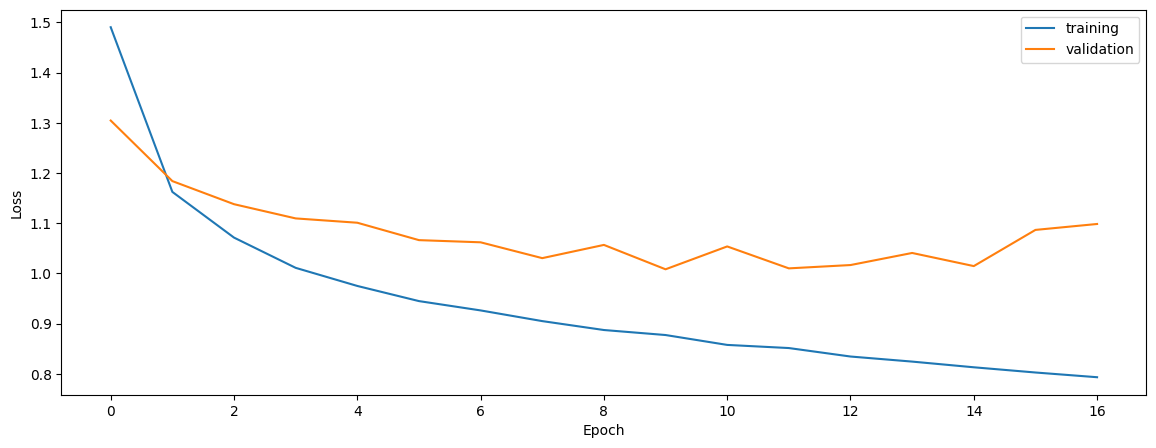

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


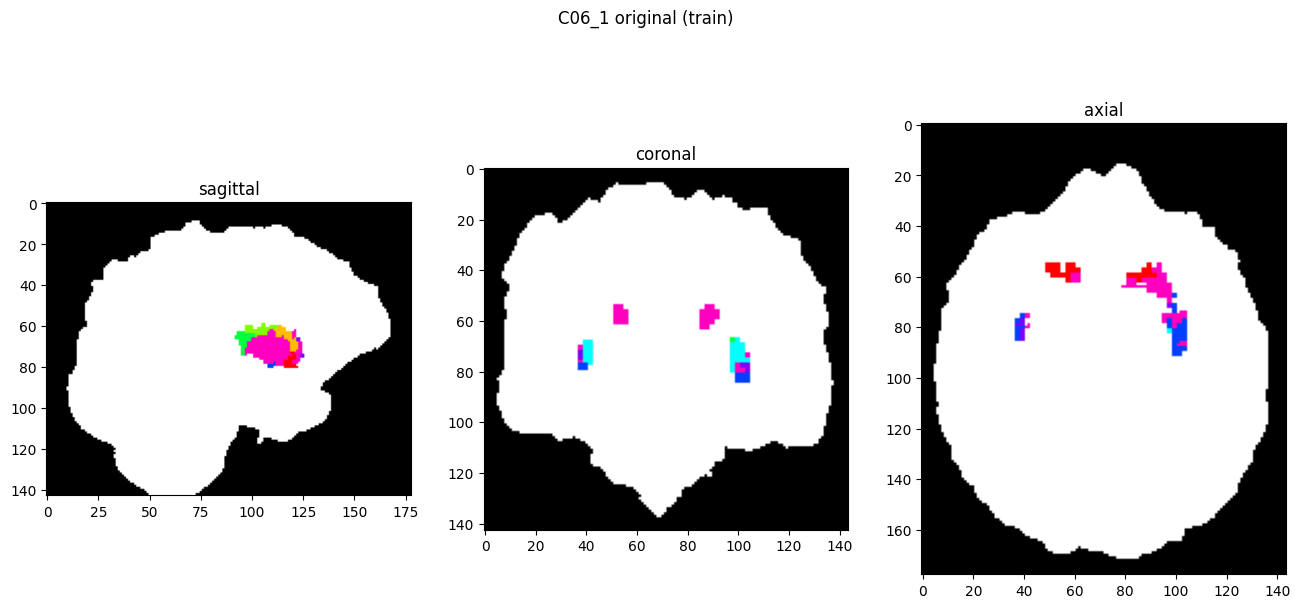

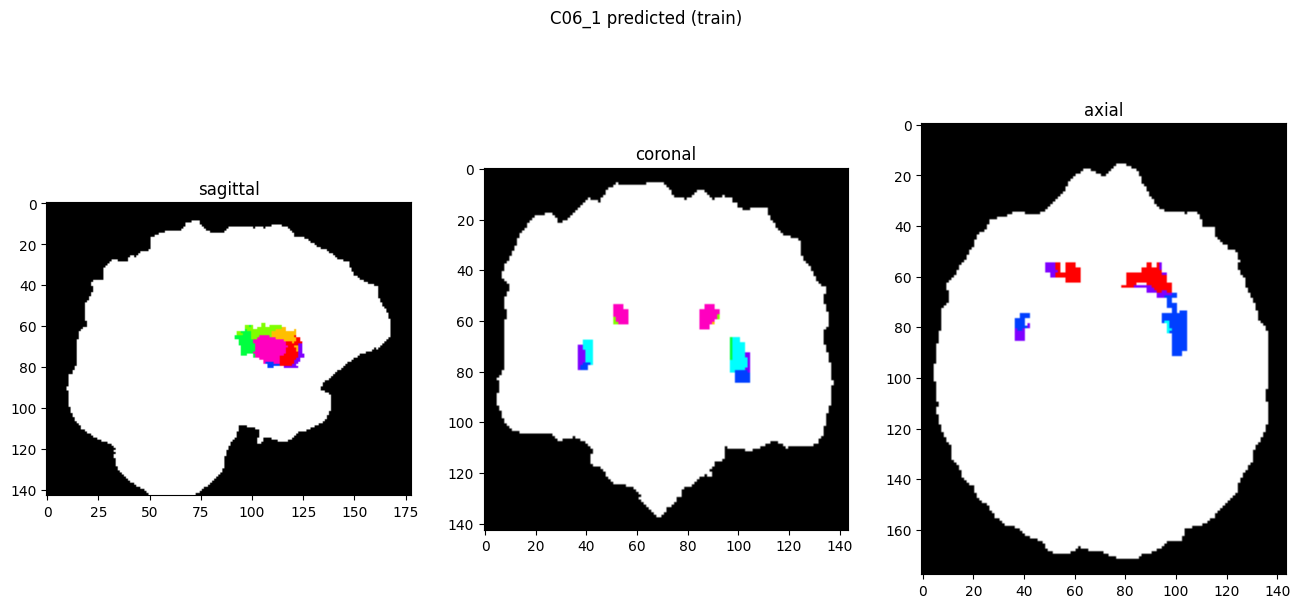

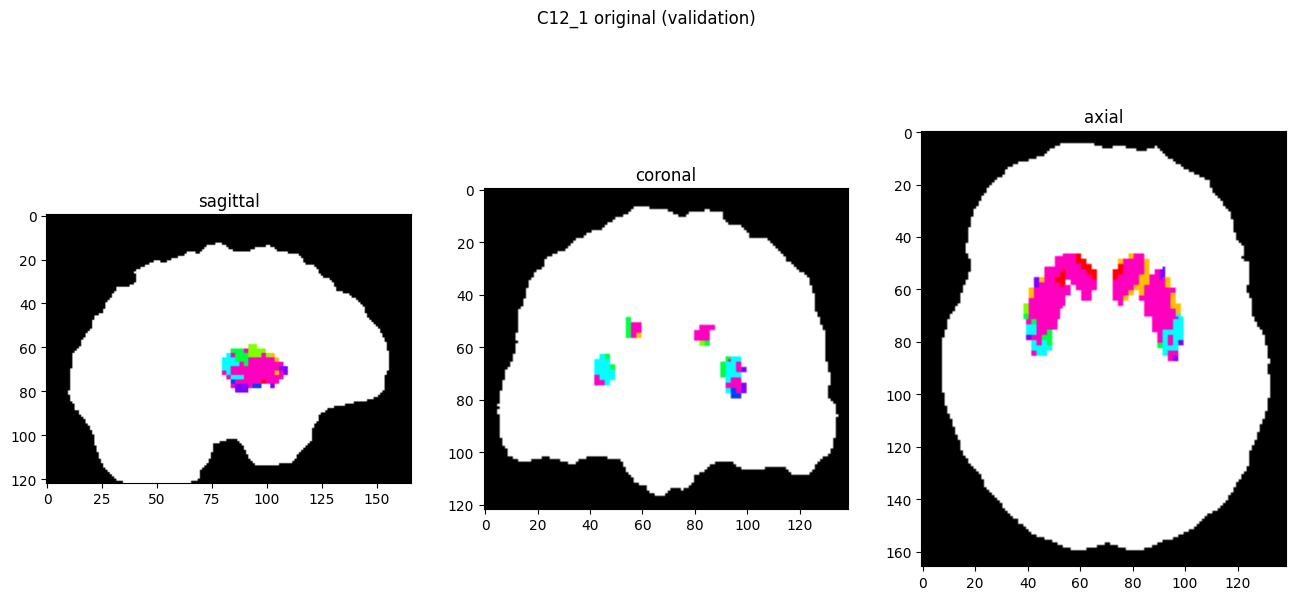

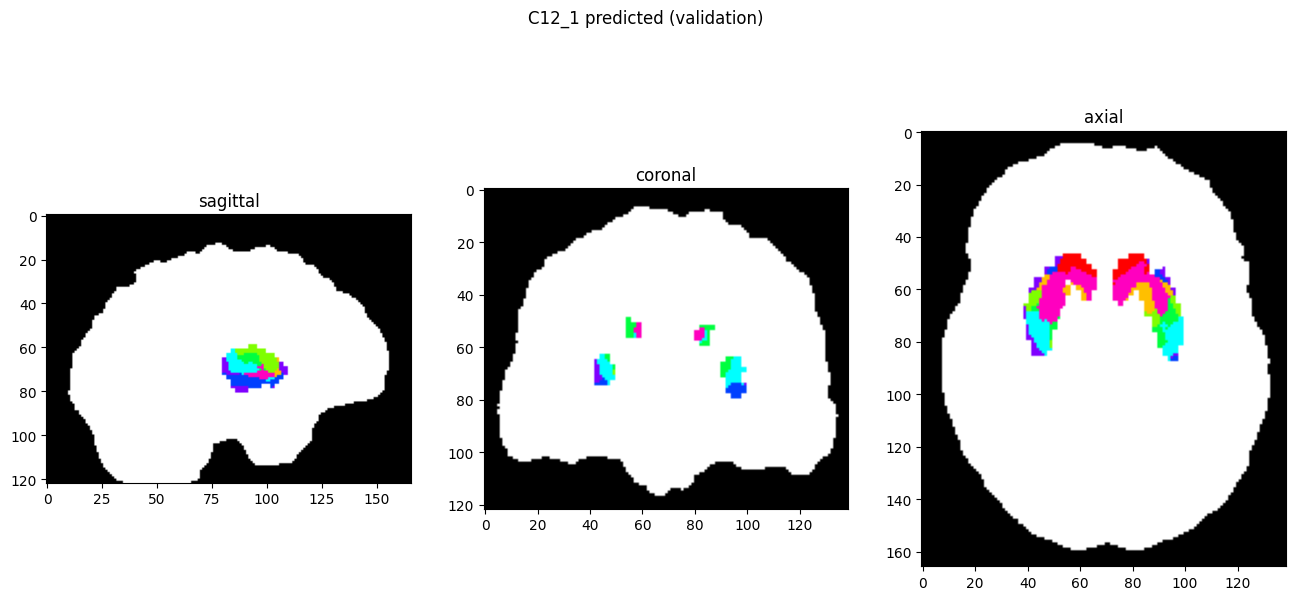

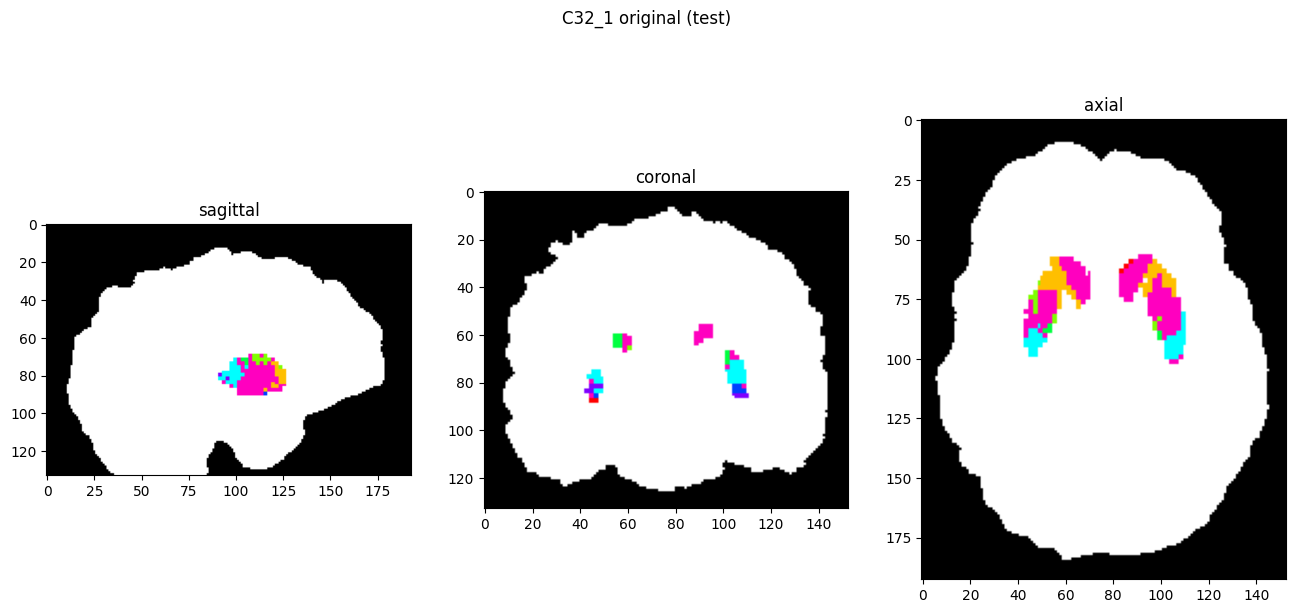

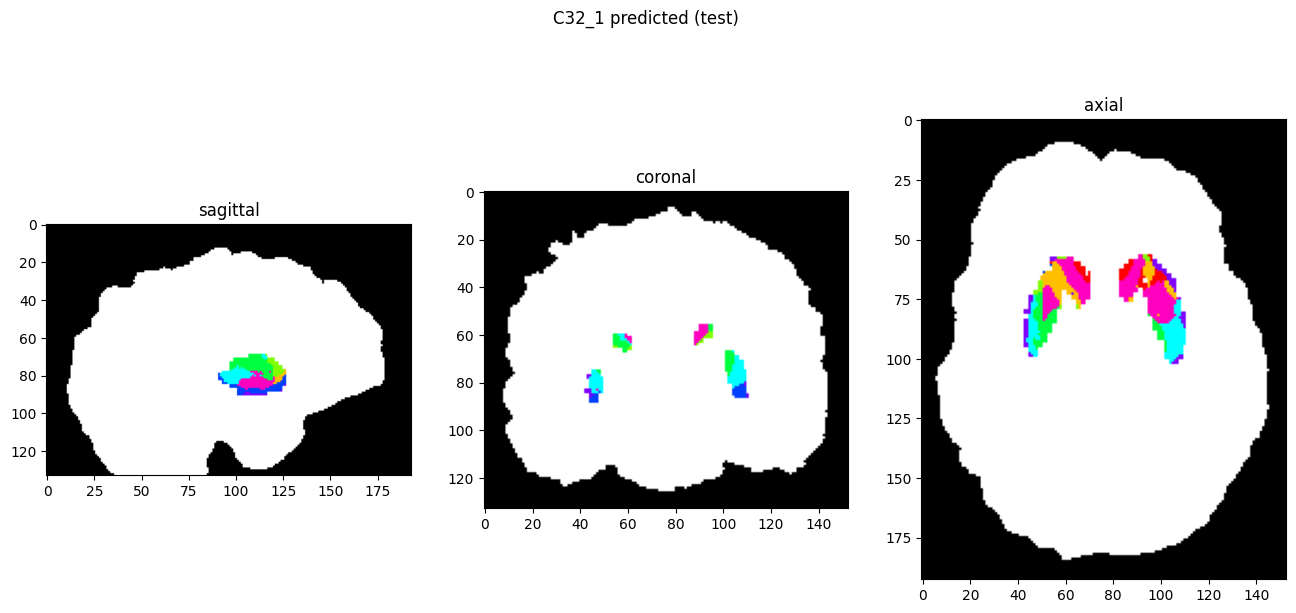

In [10]:
showResults(model, gen, threshold=0)